In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import colormaps
from scipy.optimize import curve_fit
from scipy.special import voigt_profile
from matplotlib.patches import Rectangle

In [3]:
date = "testrun_012026"

def importData(name):
    return np.genfromtxt(f"../data/{date}/{name}", delimiter=',')

def importAverages(folder):
    rawdata = importData(f"{folder}/avgdata.csv")

    omegas = np.reshape(rawdata[:, 0], [Nbins, Nbins])
    thetas = np.reshape(rawdata[:, 1], [Nbins, Nbins])
    avgOmegas = np.reshape(rawdata[:, 2], [Nbins, Nbins])
    avgThetas = np.reshape(rawdata[:, 3], [Nbins, Nbins])
    avgNum = np.reshape(rawdata[:, 4], [Nbins, Nbins])
    avgPol = np.reshape(rawdata[:, 5], [Nbins, Nbins])

    avgData = {
        "w": omegas,
        "th": thetas,
        "w_avg": avgOmegas,
        "th_avg": avgThetas,
        "N_avg": avgNum,
        "pol_avg": avgPol
    }

    return avgData

def importHistogram(folder, name):
    rawData = importData(f"{folder}/hist_{name}.csv")

    wallsData = rawData[0, :-1]
    parCountsData = rawData[1, :-2]
    perpCountsData = rawData[2, :-2]

    # Trick to deal with overflows lol. Didn't think I'd ever need this
    # Python doesn't care fortunately, because ints are implemented very smartly
    parNegMask = parCountsData < 0
    perpNegMask = perpCountsData < 0

    parCountsData[parNegMask] = 2147483647 + (parCountsData[parNegMask] + 2147483647 + 2)
    perpCountsData[perpNegMask] = 2147483647 + (perpCountsData[perpNegMask] + 2147483647 + 2)

    hist = {
        "walls": wallsData,
        "parCounts": parCountsData,
        "perpCounts": perpCountsData,
        "totalCounts": parCountsData + perpCountsData
    }

    return hist

def importAllHists(folder):
    betaHist = importHistogram(folder, "beta")
    nrgHist = importHistogram(folder, "nrg")
    thetaHist = importHistogram(folder, "theta")
    numHist = importHistogram(folder, "num")
    escapeNRGHist = importHistogram(folder, "esc_nrg")
    escapeThetaHist = importHistogram(folder, "esc_theta")

    histograms = {
        "beta": betaHist,
        "nrg": nrgHist,
        "num": numHist,
        "theta": thetaHist,
        "esc_nrg": escapeNRGHist,
        "esc_theta": escapeThetaHist
    }

    return histograms

def importHistogram2D(folder, name):
    rawData = importData(f"{folder}/hist2D_{name}.csv")

    xWallsData = rawData[0, 1:-1:2]
    yWallsData = rawData[1:, 0]
    parCountsData = rawData[1:-1, 1:-3:2]
    perpCountsData = rawData[1:-1, 2:-3:2]

    hist = {
        "xWalls": xWallsData,
        "yWalls": yWallsData,
        "parCounts": parCountsData,
        "perpCounts": perpCountsData,
        "totalCounts": parCountsData + perpCountsData
    }

    return hist

def importAll2DHists(folder):
    nrgXnrgHist = importHistogram2D(folder, "nrgXnrg")
    nrgXthetaHist = importHistogram2D(folder, "nrgXtheta")
    thetaXnrgHist = importHistogram2D(folder, "thetaXnrg")
    thetaXthetaHist = importHistogram2D(folder, "thetaXtheta")
    finalValsHist = importHistogram2D(folder, "finalVals")

    histograms = {
        "nrgXnrg": nrgXnrgHist,
        "nrgXtheta": nrgXthetaHist,
        "thetaXnrg": thetaXnrgHist,
        "thetaXtheta": thetaXthetaHist,
        "finalVals": finalValsHist
    }

    return histograms

rawParams = importData("simParams.csv")

Nparticles = rawParams[0]
Nbins = rawParams[1].astype(int)
simType = rawParams[2]

folderNames = ["00", "01", "10", "11"]

avgData = []
hists = []
hists2D = []

for folder in folderNames:
    avgData.append(importAverages(folder))
    hists.append(importAllHists(folder))
    hists2D.append(importAll2DHists(folder))

myMap = 'inferno'

def titleFromFolder(folder):
    Theta = 0
    pol = ""
    recoil = ""

    if folder[0] == "0":
        Theta = 0.05
        if "lowertemps" in date: Theta = 0.01
    else:
        Theta = 0.025
        if "lowertemps" in date: Theta = 0.005

    if folder[1] == "0":
        recoil = "No Recoil"
    else:
        recoil = "Recoil"

    return rf"{recoil}, $\Theta=$ {Theta}"

def plotAllKeys(keys, plotFunc):
    # Loop over every key (diff for hists vs avg data)
    for key in keys:
        
        # 1x4 subplot to show them all
        fig, axes = plt.subplots(1, 4, figsize=(22, 10))

        for i in range(4):

            plotFunc(key, i, axes[i])

        plt.show()



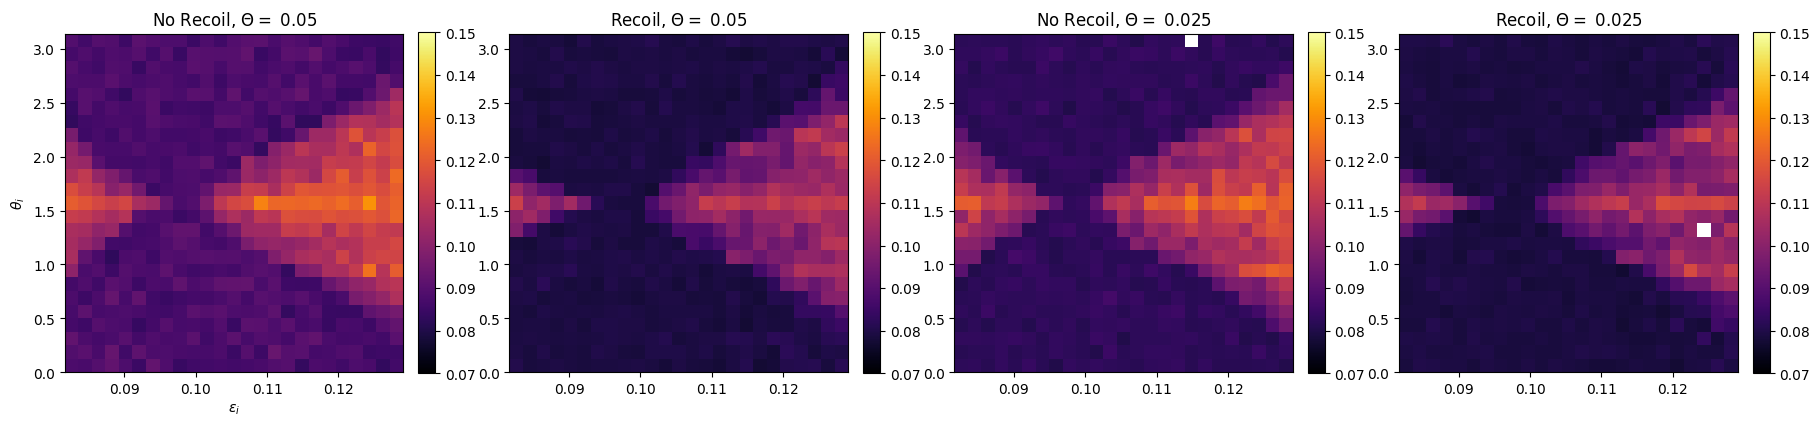

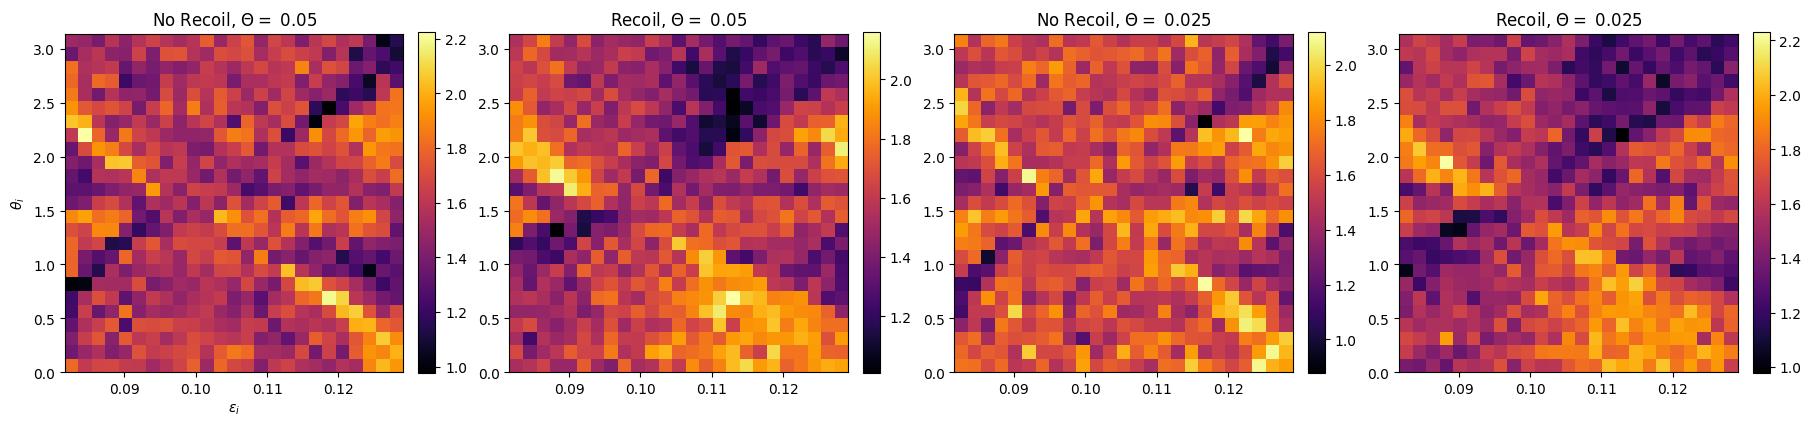

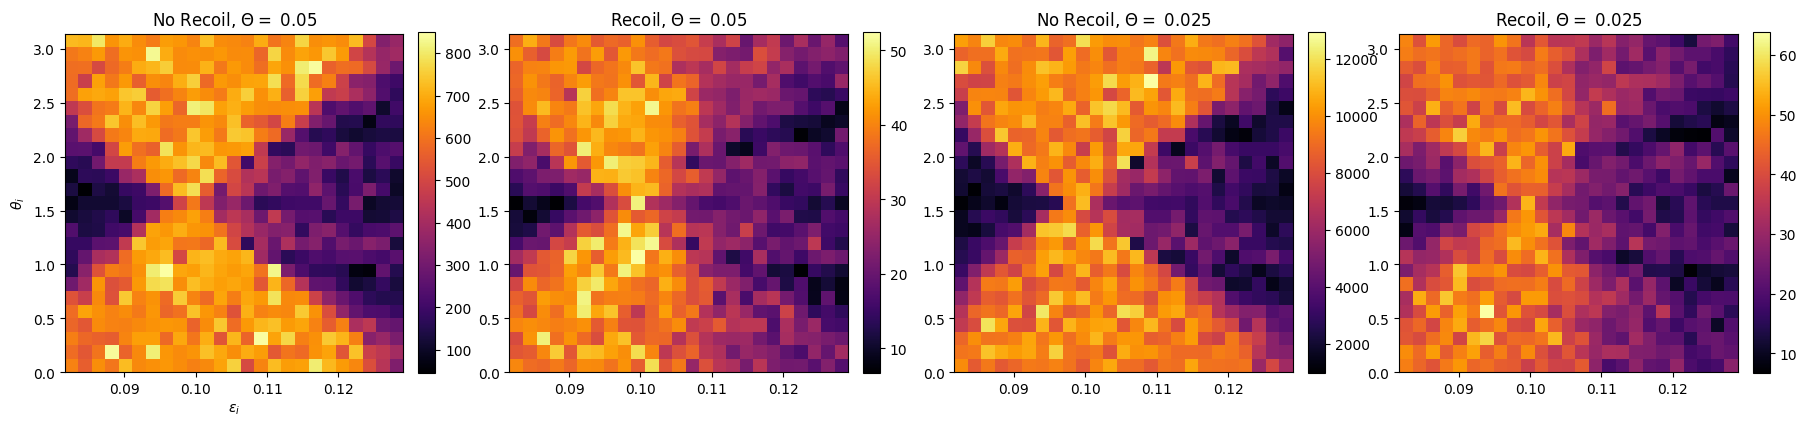

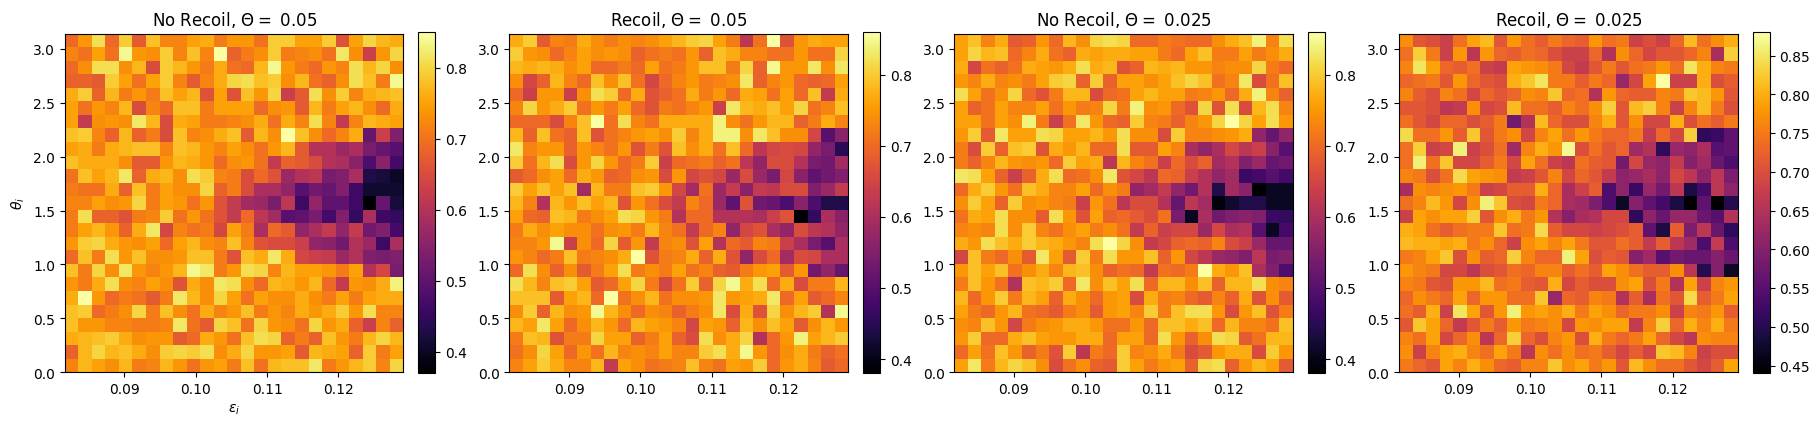

In [4]:
def plotAvgData(key, i, ax):
    # Get relevant average data
    thisAvgDict = avgData[i]

    omegas = thisAvgDict["w"]
    thetas = thisAvgDict["th"]
    plotVal = thisAvgDict[f"{key}_avg"]

    if (key == "w"):
        image = ax.pcolormesh(omegas, thetas, plotVal, cmap=myMap, norm=colors.Normalize(7e-2, 1.5e-1))
    else:
        image = ax.pcolormesh(omegas, thetas, plotVal, cmap=myMap)

    if (i == 0):
        ax.set_xlabel(fr"$\varepsilon_i$")
        ax.set_ylabel(fr"$\theta_i$")

    cbar = plt.colorbar(image, ax=ax, fraction=0.046, pad=0.04)

    # if (ind != 3 and key == "w"):
    #     cbar.set_ticks([])

    ax.set_box_aspect(1)

    # figure out the title
    ax.set_title(titleFromFolder(folderNames[i]))

plotAllKeys(["w", "th", "N", "pol"], plotAvgData)

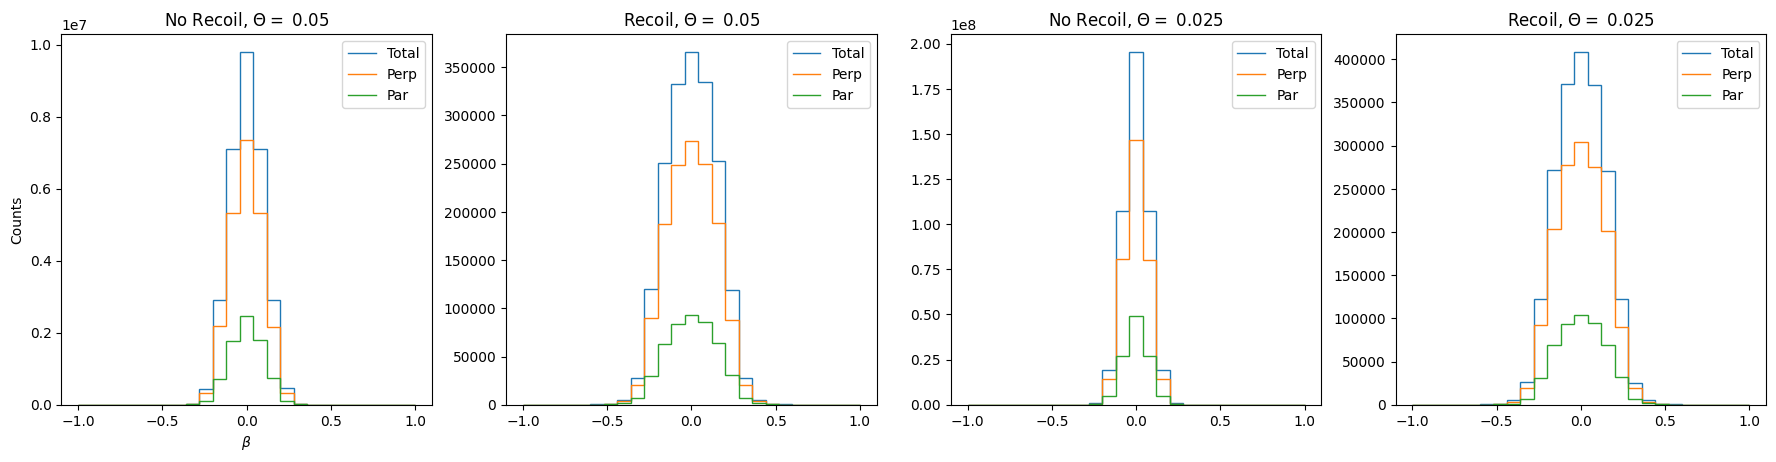

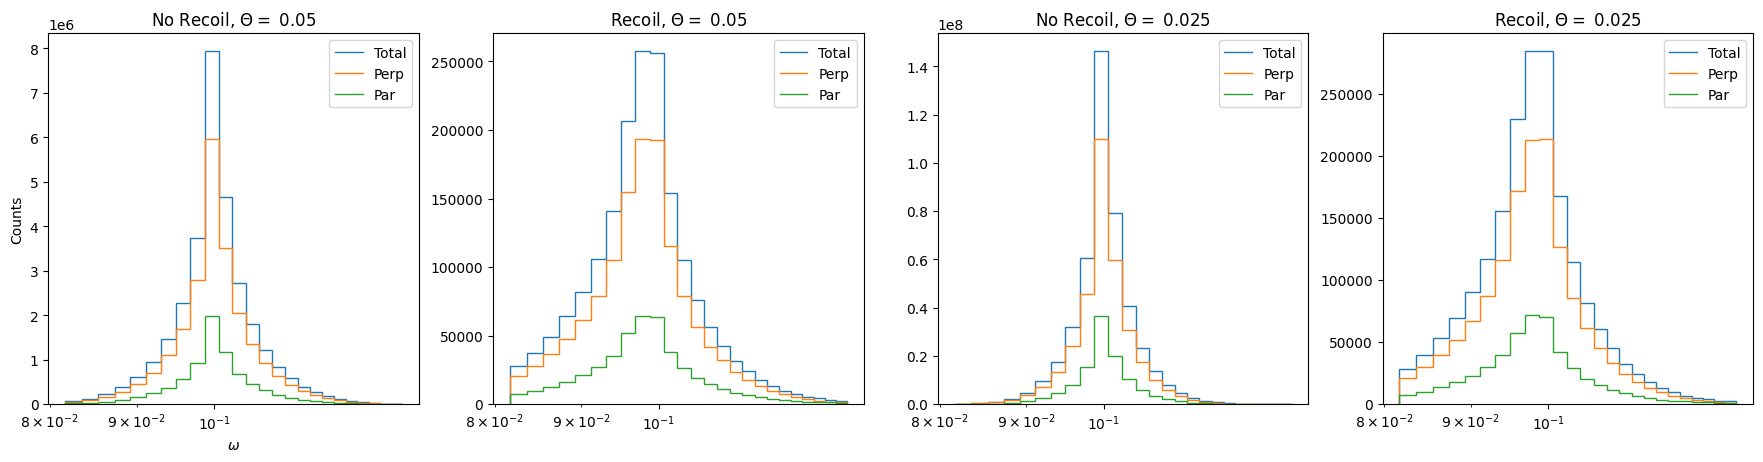

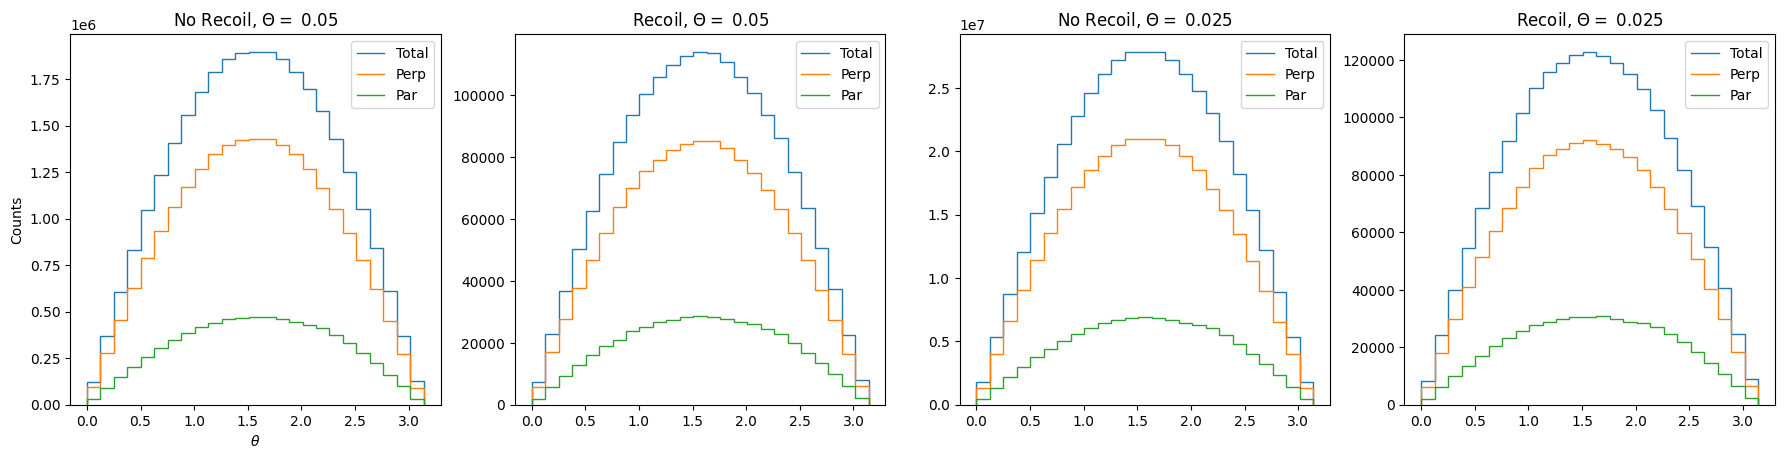

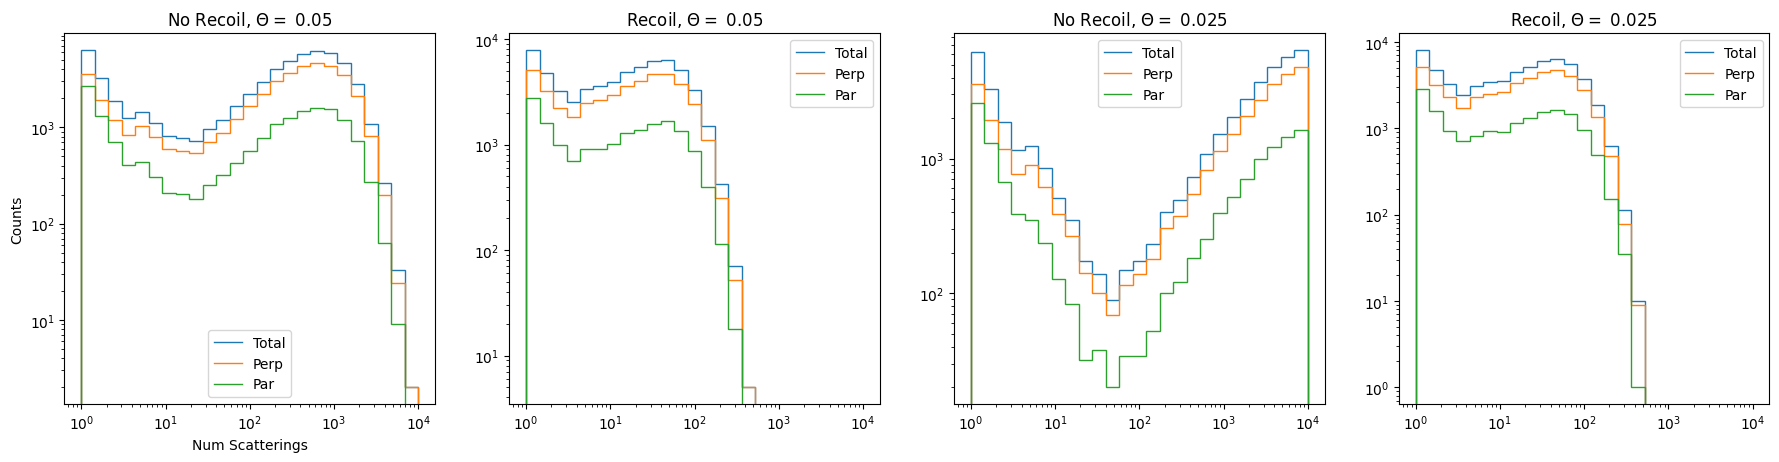

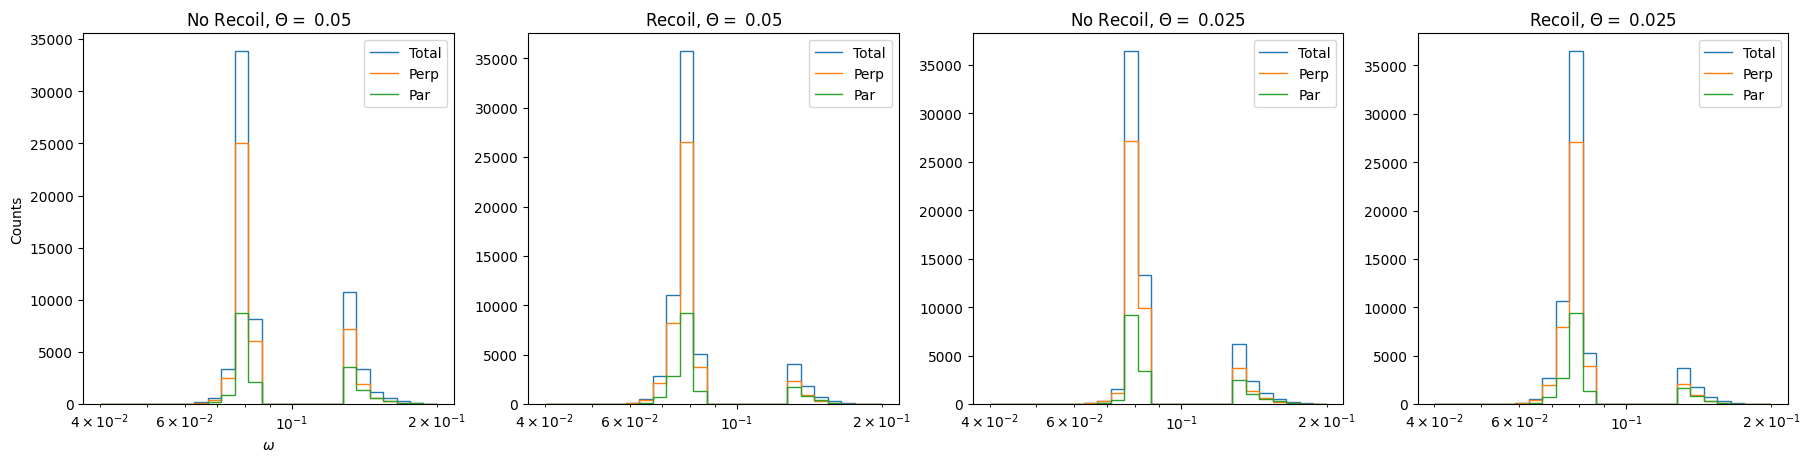

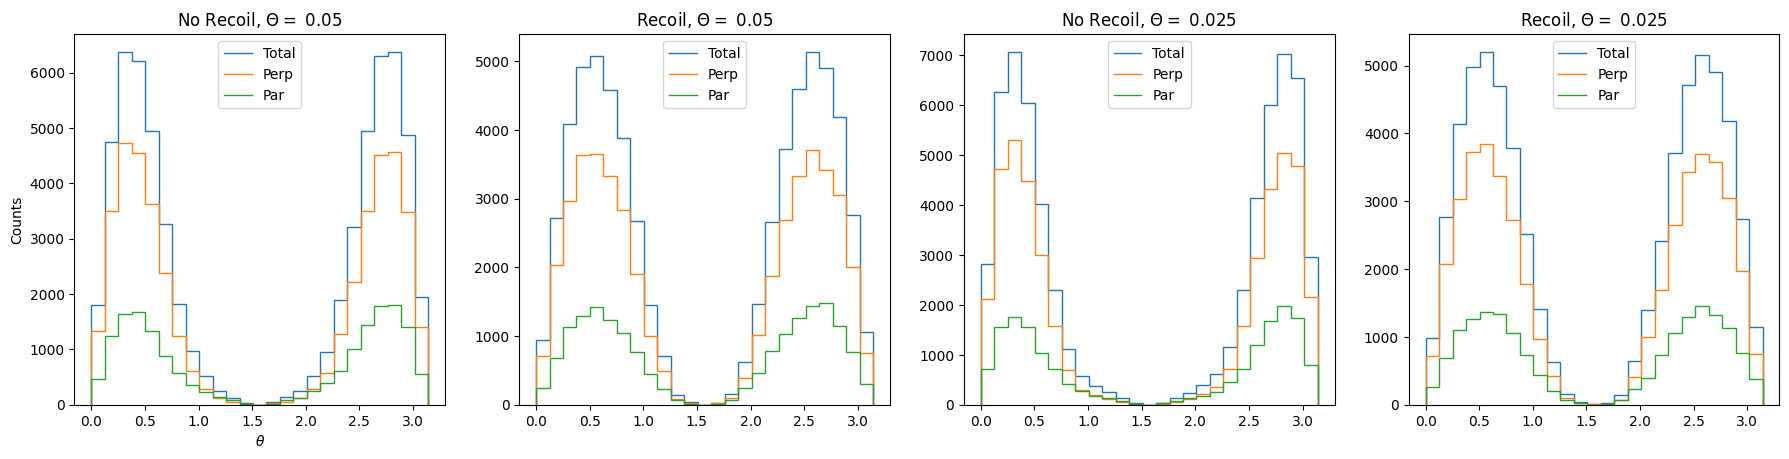

In [5]:
def plotHistData(key, i, ax):
    # Get relevant average data
    thisHist = hists[i][key]

    ax.stairs(thisHist["totalCounts"], thisHist["walls"], fill=False)
    ax.stairs(thisHist["perpCounts"], thisHist["walls"], fill=False)
    ax.stairs(thisHist["parCounts"], thisHist["walls"], fill=False)

    ax.legend(["Total", "Perp", "Par"])
    

    if (i == 0):
        match (key):
            case "beta":
                name = r"$\beta$"
            case "nrg" | "esc_nrg":
                name = r"$\omega$"
            case "num":
                name = "Num Scatterings"
            case "theta" | "esc_theta":
                name = r"$\theta$"
        ax.set_xlabel(name)
        ax.set_ylabel("Counts")

    ax.set_box_aspect(1)

    match (key):
        case "nrg" | "esc_nrg":
            ax.set_xscale('log')
        case "num":
            ax.set_xscale('log')
            ax.set_yscale('log')

    ax.set_title(titleFromFolder(folderNames[i]))

plotAllKeys(["beta", "nrg", "theta", "num", "esc_nrg", "esc_theta"], plotHistData)

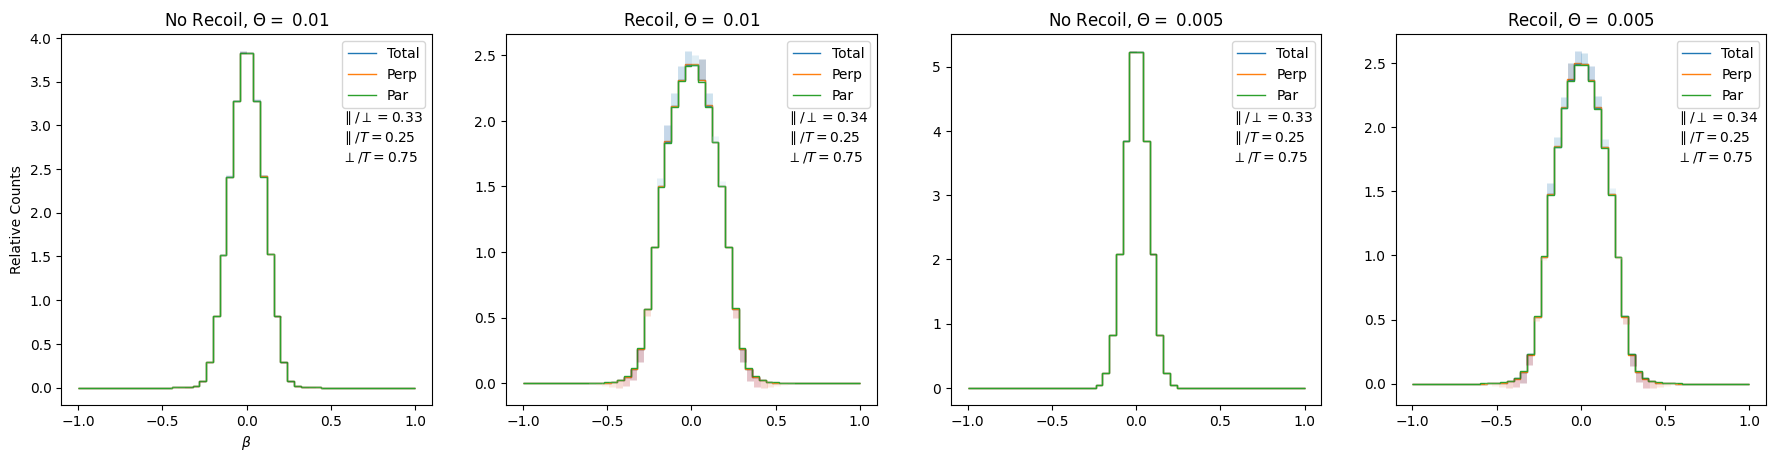

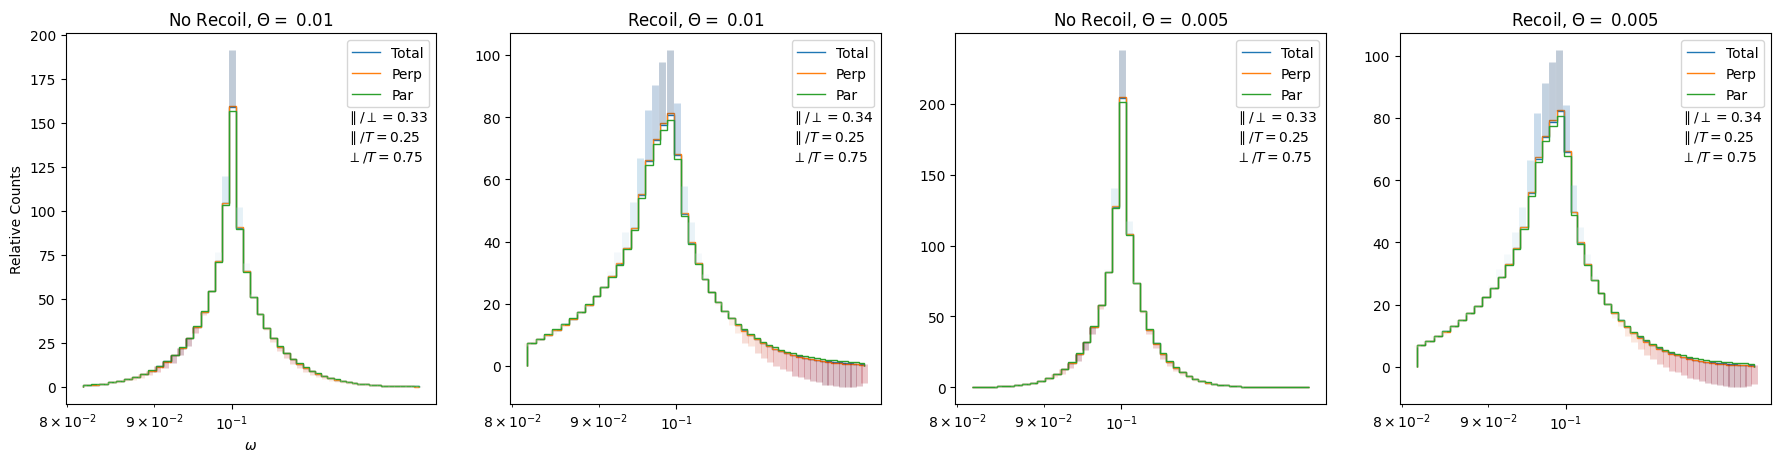

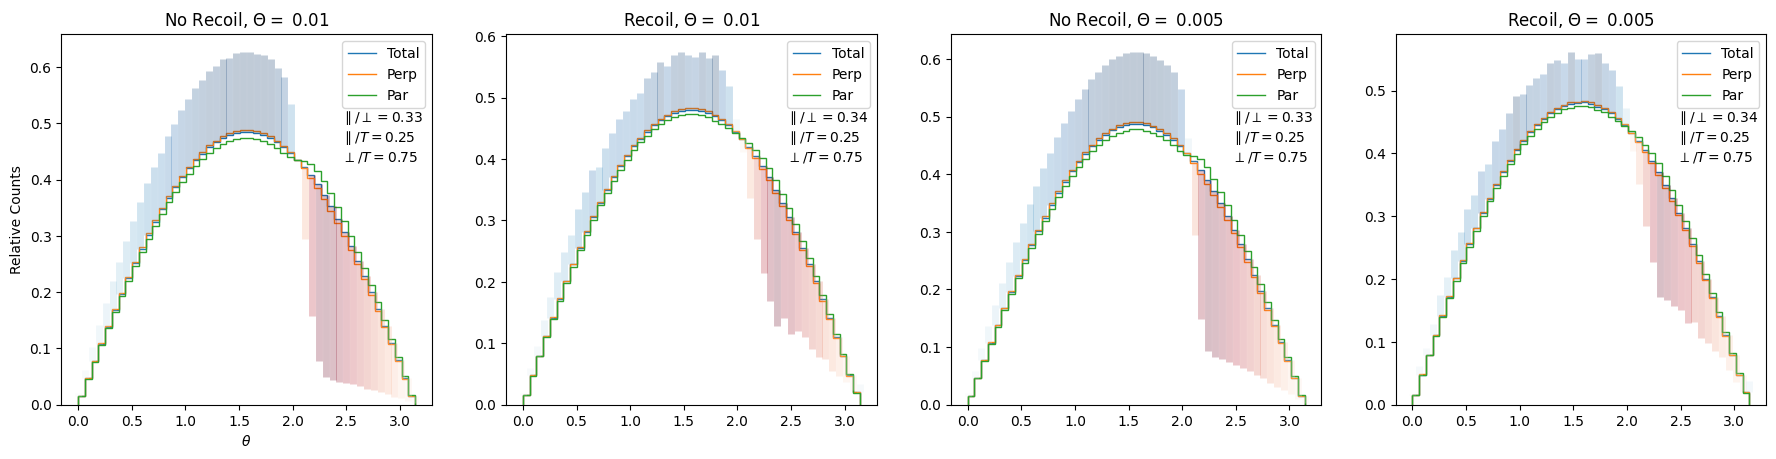

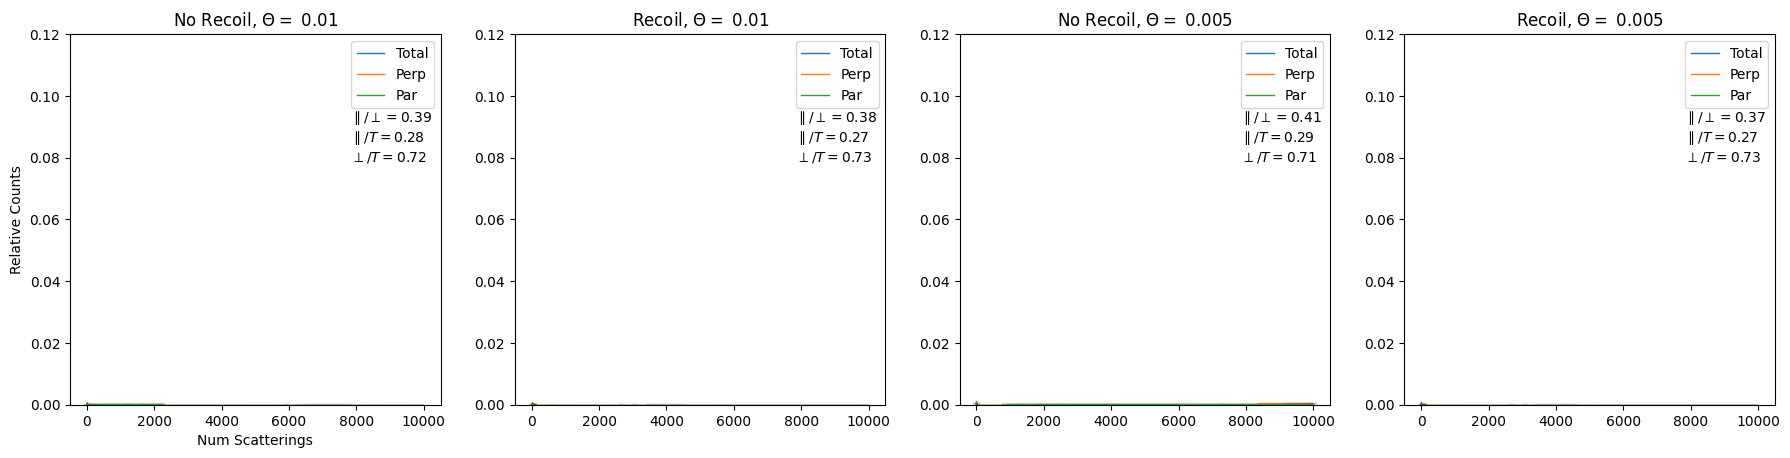

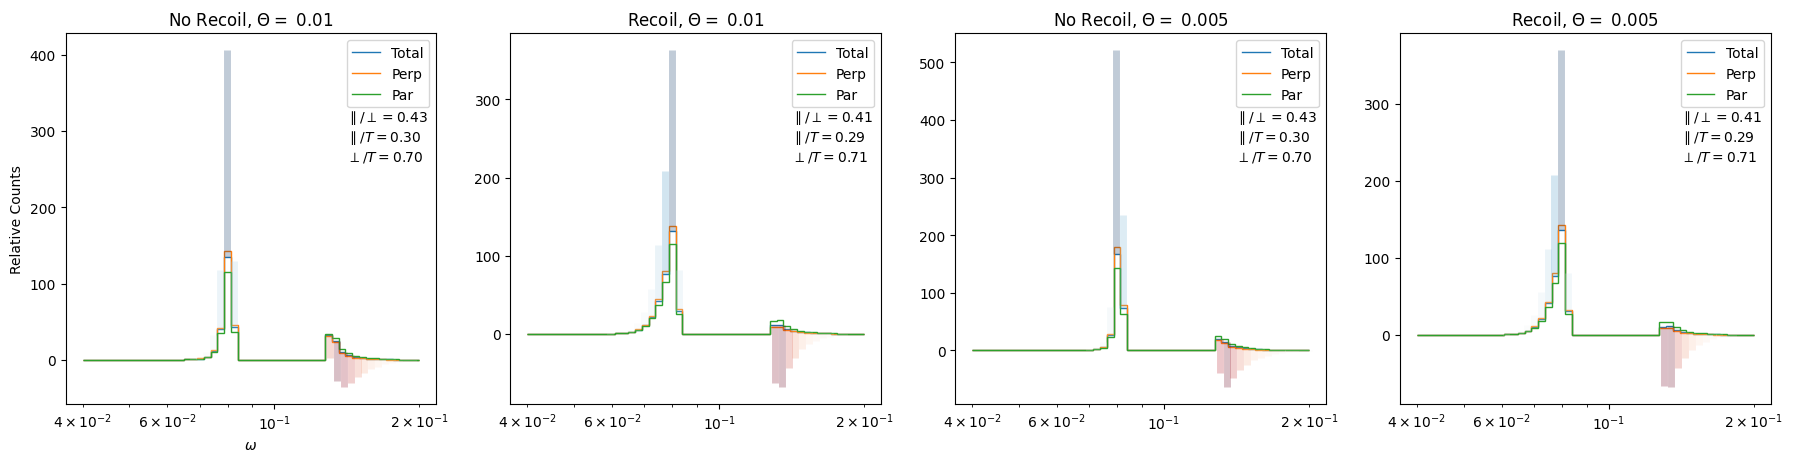

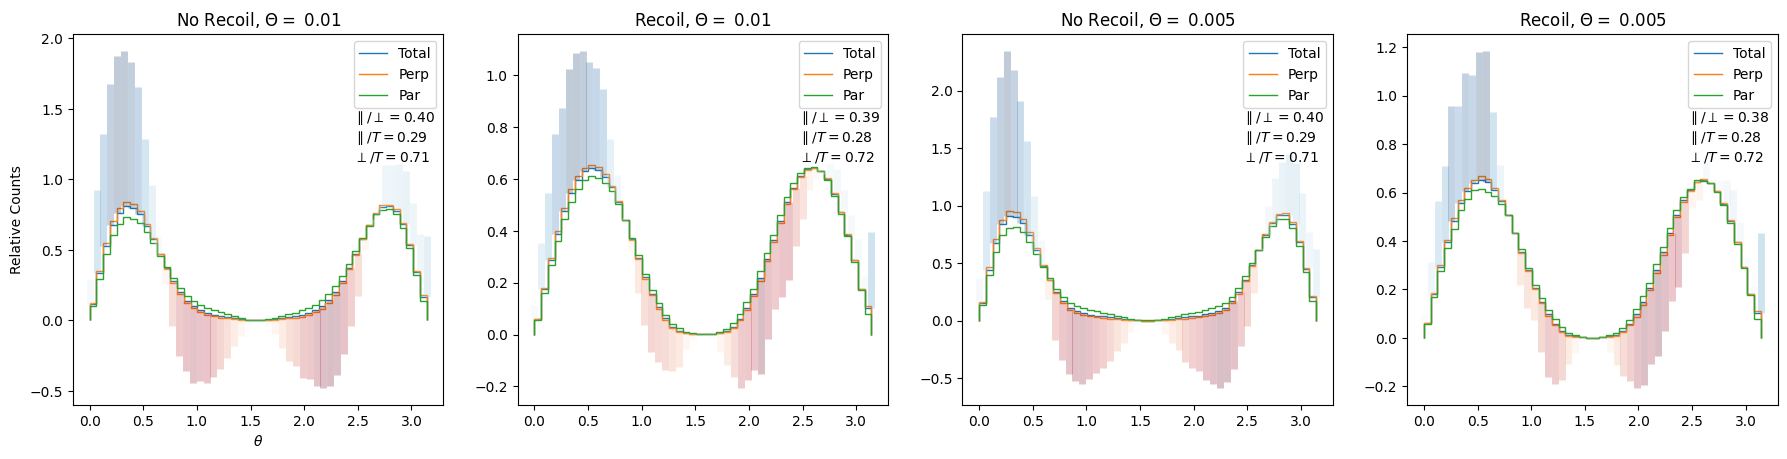

In [29]:
def plotNormHistData(key, i, ax):
    thisHist = hists[i][key]

    xWalls = thisHist["walls"]
    xVals = np.linspace(xWalls[0], xWalls[-1], xWalls.size-1) 

    match (key):
        case "nrg":
            ax.set_xscale('log')
        case "esc_nrg":
            ax.set_xscale('log')
            xVals = np.logspace(np.log10(xWalls[0]), np.log10(xWalls[-1]), xWalls.size-1)
        case "num":
            ax.set_ylim([0, 0.12])

    relCountList = []

    # Adjust the counts so that the integral is 1
    for count in ("totalCounts", "perpCounts", "parCounts"):
        relCounts = thisHist[count]/np.trapezoid(thisHist[count], xVals)

        relCountList.append(relCounts)

        ax.stairs(relCounts, xWalls, fill=False)

    leg = ax.legend(["Total", "Perp", "Par"])

    perpMinusPar = (relCountList[1] - relCountList[2])*10

    divnorm=colors.TwoSlopeNorm(vcenter=0.)
    errorCM= colormaps.get_cmap("RdBu")
    errorColors = errorCM(divnorm(perpMinusPar))

    errorColors[:, 3] = 0.25

    ax.errorbar(xVals, relCountList[0], yerr=(np.where(perpMinusPar < 0, np.abs(perpMinusPar), 0), np.where(perpMinusPar > 0, perpMinusPar, 0)),
                fmt='none', elinewidth=5, ecolor=errorColors)

    parOverPerp = np.trapezoid(thisHist["parCounts"], xVals)/np.trapezoid(thisHist["perpCounts"], xVals)
    parOverTotal = np.trapezoid(thisHist["parCounts"], xVals)/np.trapezoid(thisHist["totalCounts"], xVals)
    perpOverTotal = np.trapezoid(thisHist["perpCounts"], xVals)/np.trapezoid(thisHist["totalCounts"], xVals)

    ratioText = (rf"$\parallel/\perp={parOverPerp:.2f}$" "\n" 
                rf"$\parallel/T={parOverTotal:.2f}$" "\n"
                rf"$\perp/T={perpOverTotal:.2f}$" "\n")

    fig = ax.get_figure()
    fig.canvas.draw()
    bbox = leg.get_window_extent()

    inv = fig.transFigure.inverted()
    bbox_fig = inv.transform_bbox(bbox)

    ax.text(bbox_fig.x0, bbox_fig.y0-0.2, ratioText, transform=fig.transFigure, va="top")
    

    if (i == 0):
        match (key):
            case "beta":
                name = r"$\beta$"
            case "nrg" | "esc_nrg":
                name = r"$\omega$"
            case "num":
                name = "Num Scatterings"
            case "theta" | "esc_theta":
                name = r"$\theta$"
        ax.set_xlabel(name)
        ax.set_ylabel("Relative Counts")

    ax.set_box_aspect(1)

    ax.set_title(titleFromFolder(folderNames[i]))

plotAllKeys(["beta", "nrg", "theta", "num", "esc_nrg", "esc_theta"], plotNormHistData)

4.0250603102268134e-08
-4.0656773599503926e-07
-8.108641200979191e-10
4.171165889702011e-07


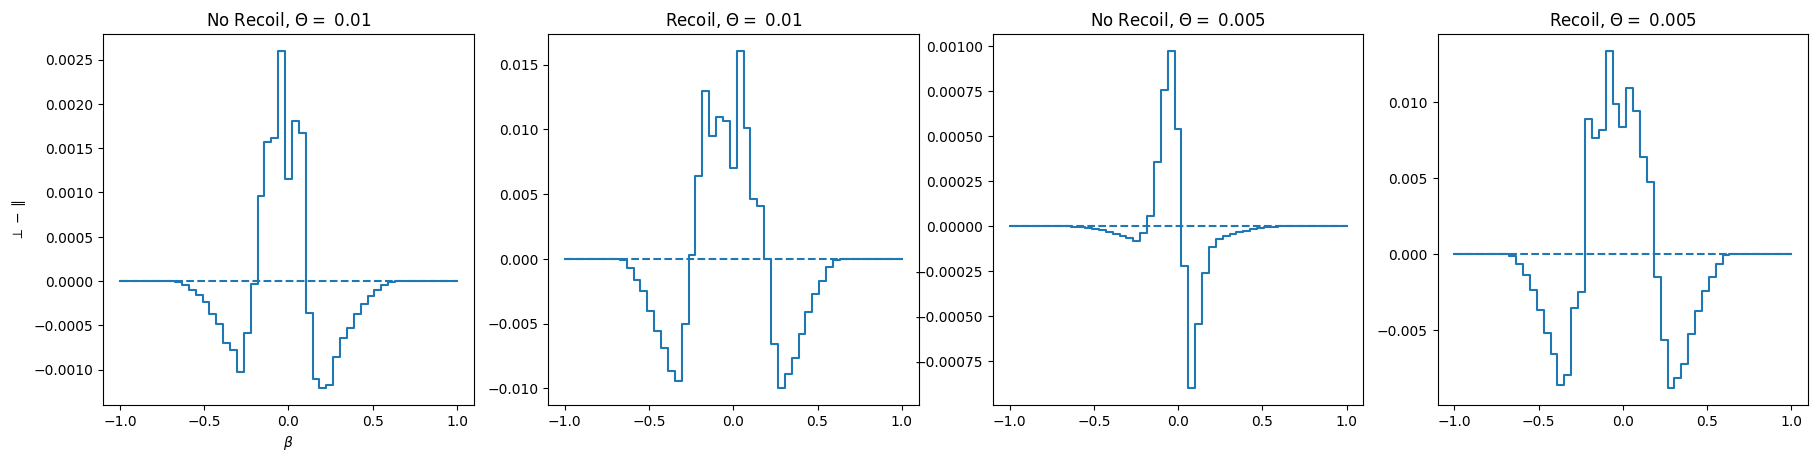

-0.0343049808337797
-0.3606029587118954
-0.0029111379384680267
-0.33361793816150864


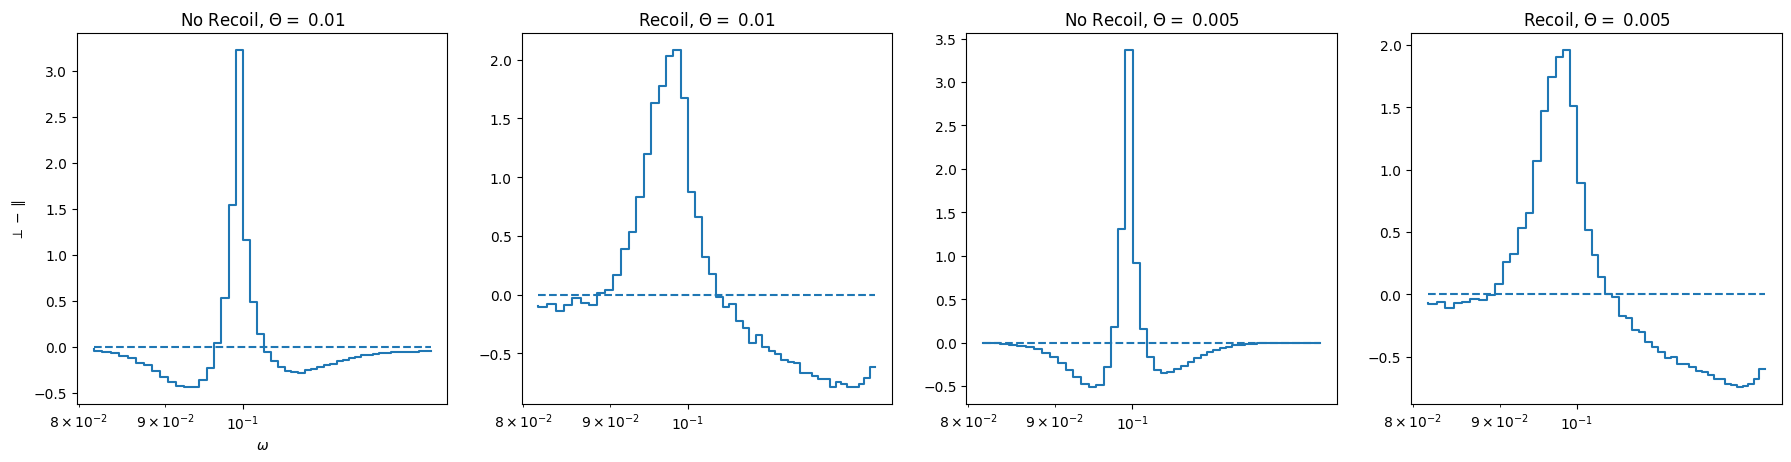

-0.00039179019403036766
0.0007806787800443034
-0.00038833242223442616
0.000938200330148662


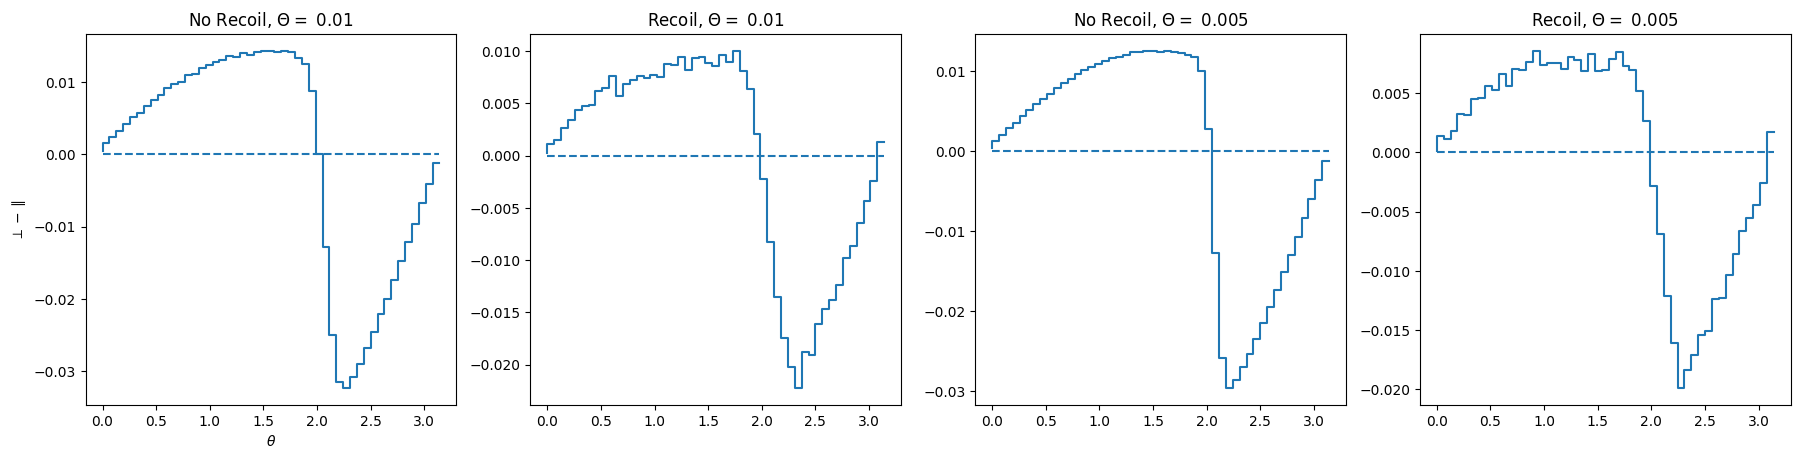

-0.00017586593559324623
-0.00013974212829944736
-0.00020262941240507408
-0.00013539658009082832


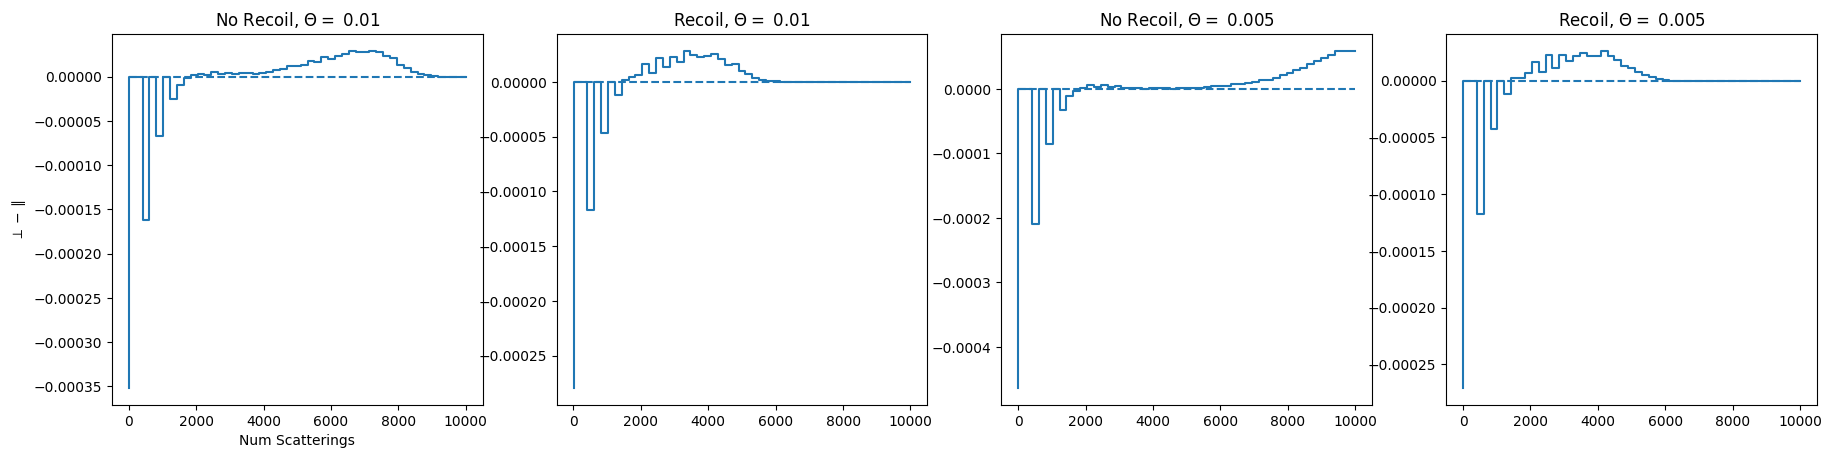

-0.04568129390674108
-0.006202429535489299
-0.05359520743115696
-0.006379677398850203


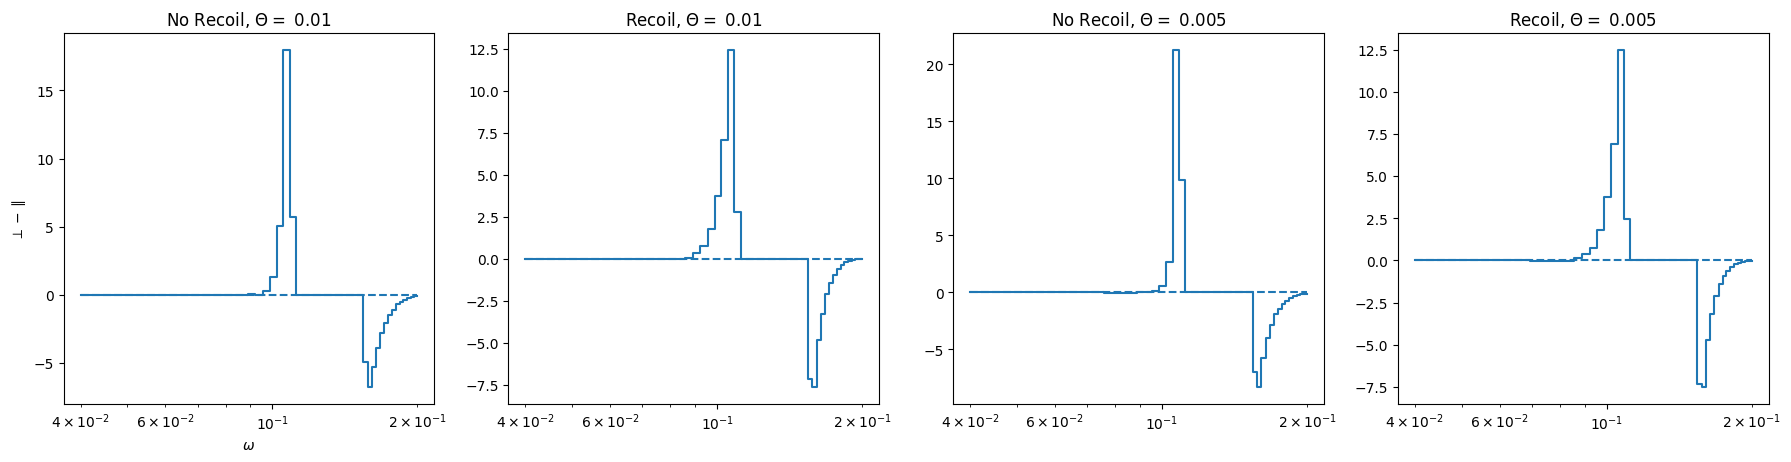

0.030281645167220067
0.017546490582468287
0.03187238217152717
0.018441150862811503


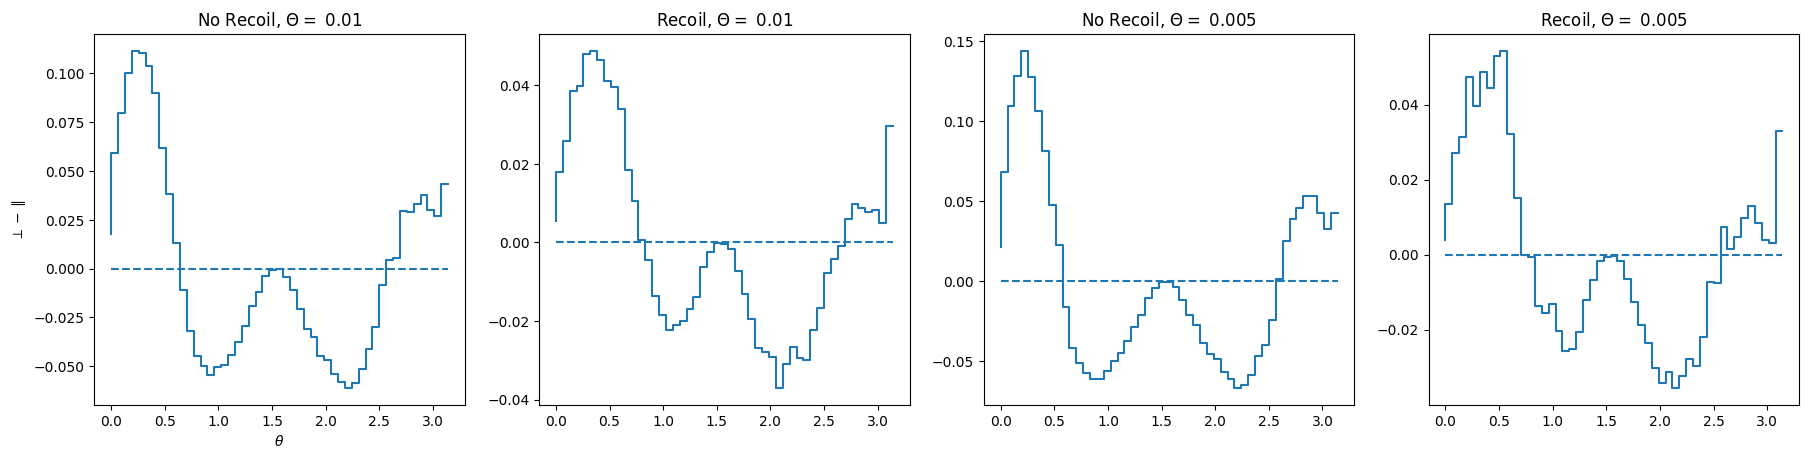

In [30]:
def plotHistDiffs(key, i, ax):
    # Get relevant average data
    thisHist = hists[i][key]

    xWalls = thisHist["walls"]
    xVals = np.linspace(xWalls[0], xWalls[-1], xWalls.size-1) 

    # Adjust the counts so that the integral is 1
    parRelCounts = thisHist["parCounts"]/np.trapezoid(thisHist["parCounts"], xVals)
    perpRelCounts = thisHist["perpCounts"]/np.trapezoid(thisHist["perpCounts"], xVals)

    plotVals = perpRelCounts - parRelCounts

    print(np.sum(plotVals))

    ax.step(xVals, plotVals)
    ax.hlines(0, xVals[0], xVals[-1], linestyles="--")
    
    if (i == 0):
        match (key):
            case "beta":
                name = r"$\beta$"
            case "nrg" | "esc_nrg":
                name = r"$\omega$"
            case "num":
                name = "Num Scatterings"
            case "theta" | "esc_theta":
                name = r"$\theta$"
        ax.set_xlabel(name)
        ax.set_ylabel(r"$\perp - \parallel$")

    ax.set_box_aspect(1)

    match (key):
        case "nrg" | "esc_nrg":
            ax.set_xscale('log')

    ax.set_title(titleFromFolder(folderNames[i]))

plotAllKeys(["beta", "nrg", "theta", "num", "esc_nrg", "esc_theta"], plotHistDiffs)

C:\Users\oscar\AppData\Local\Temp\ipykernel_28804\958963870.py:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(1.0 / (2 * np.pi * Theta)) * np.exp(-x**2 / (2 * Theta))


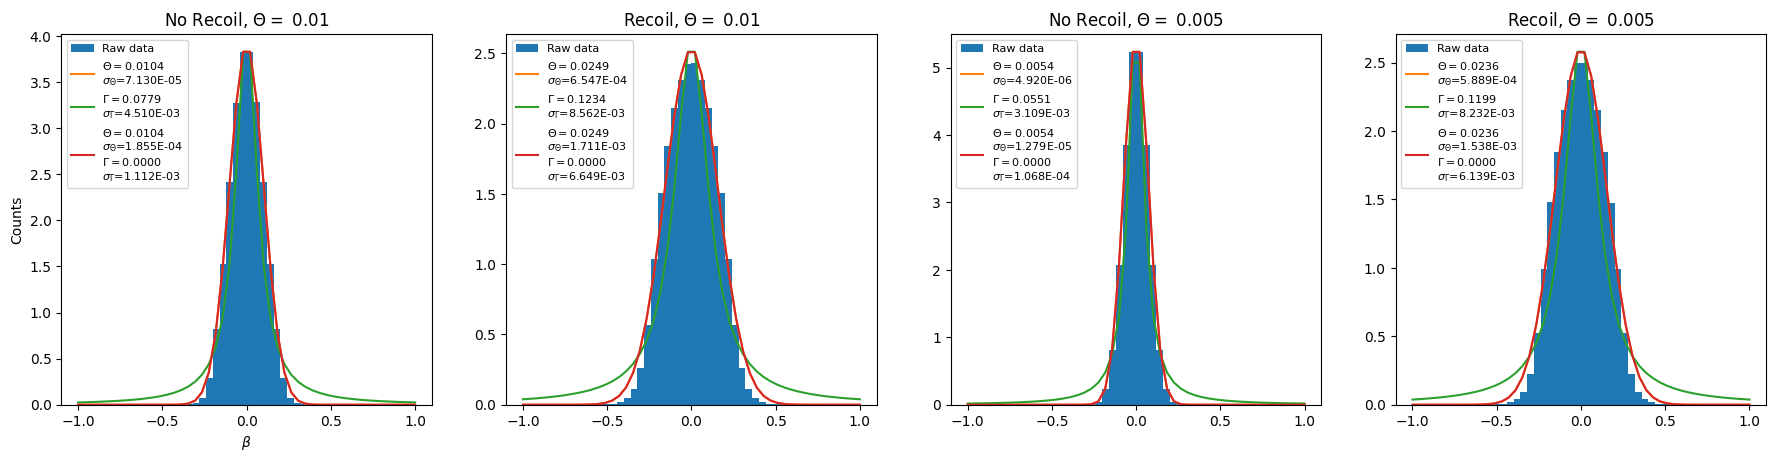

In [31]:
# beta fits

def MBdistb(x, Theta):
    return np.sqrt(1.0 / (2 * np.pi * Theta)) * np.exp(-x**2 / (2 * Theta))

def lorentzian(x, Gamma):
    return Gamma / (np.pi * ((x)**2 + Gamma**2))

def voigt(x, Theta, Gamma):
    # Note: scipy defines in terms of sigma = sqrt(Theta)
    return voigt_profile(x, np.sqrt(Theta), Gamma)

def plotBetaFits(key, i, ax):
    # Get relevant average data
    thisHist = hists[i][key]

    # Define beta values as the center of each bin
    betaWalls = thisHist["walls"]
    betaVals = np.linspace(betaWalls[0], betaWalls[-1], betaWalls.size-1) 

    # Adjust the counts so that the integral is 1
    countType = "totalCounts"
    relCounts = thisHist[countType]/np.trapezoid(thisHist[countType], betaVals)

    # Scatter of hist vals
    # ax.scatter(betaVals, relCounts, marker=".")
    ax.stairs(relCounts, thisHist["walls"], fill=True)

    # Get MB fit
    fitTemp, mbVar = curve_fit(MBdistb, betaVals, relCounts, p0=0.05)

    ax.plot(betaVals, MBdistb(betaVals, fitTemp), "tab:orange")

    # Get lorentzian fit
    fitGamma, lVar = curve_fit(lorentzian, betaVals, relCounts, p0=0.05)

    ax.plot(betaVals, lorentzian(betaVals, fitGamma), "tab:green")

    # Get voigt fit
    voigtParams, voigtVar = curve_fit(voigt, betaVals, relCounts, p0=[0.05, 0.2], bounds=([0,0],[np.inf,np.inf]))

    ax.plot(betaVals, voigt(betaVals, voigtParams[0], voigtParams[1]), "tab:red")

    # legend for important numbers
    ax.legend(["Raw data", 
                rf"$\Theta={fitTemp.flatten()[0]:.4f}$" + "\n" + r"$\sigma_{\Theta}$" + f"={np.sqrt(mbVar.flatten()[0]):.3E}",
                rf"$\Gamma={fitGamma.flatten()[0]:.4f}$" + "\n" + r"$\sigma_{\Gamma}$" + f"={np.sqrt(lVar.flatten()[0]):.3E}",
                rf"$\Theta={voigtParams[0]:.4f}$" + "\n" + r"$\sigma_{\Theta}$" + f"={np.sqrt(voigtVar[0][0]):.3E}" + "\n" +
                rf"$\Gamma={voigtParams[1]:.4f}$" + "\n" + r"$\sigma_{\Gamma}$" + f"={np.sqrt(voigtVar[1][1]):.3E}"],
                loc="upper left",
                prop={'size': 8})


    if (i == 0):
        ax.set_xlabel(r"$\beta$")
        ax.set_ylabel("Counts")

    ax.set_box_aspect(1)

    # figure out the title
    ax.set_title(titleFromFolder(folderNames[i]))

plotAllKeys(["beta"], plotBetaFits)

/var/folders/k4/x75xp3ss08s4tmm81wrf9vh80000gp/T/ipykernel_79235/4105284307.py:13: RuntimeWarning: invalid value encountered in sqrt
  return voigt_profile(x - muL, np.sqrt(Theta), Gamma)
/var/folders/k4/x75xp3ss08s4tmm81wrf9vh80000gp/T/ipykernel_79235/4105284307.py:49: RuntimeWarning: invalid value encountered in sqrt
  rf"$\Gamma={SigBGfit.flatten()[1]:.4f}$" + "\n" + r"$\sigma_{\Gamma}$" + f"={np.sqrt(sigBGVar.flatten()[1]):.3E}",


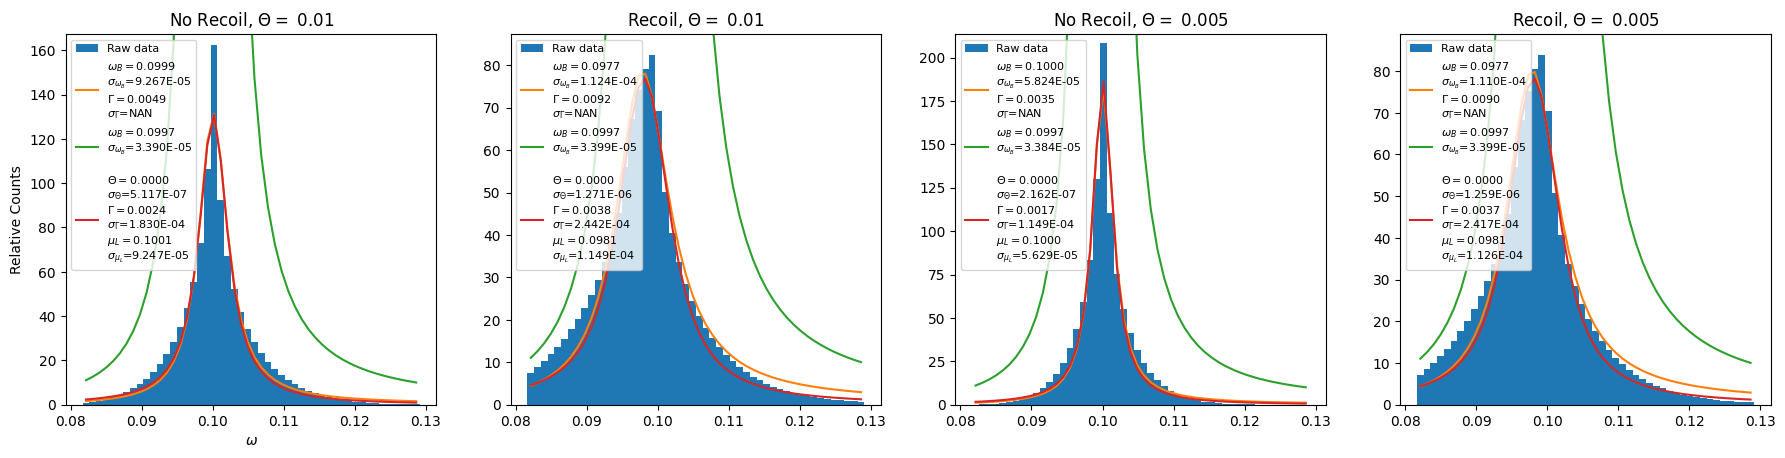

In [12]:
# nrg hists
def SigBG(w, wB, G, A):
    return A * w*w*(w**2 + wB**2)/(G**2*w**2 + (w**2 - wB**2 - 0.25*G**2)**2)

def SigB(w, wB):
    return w*w*(w*w + wB*wB)/(w*w - wB*wB)**2

def nonCenteredNrgVoigt(x, Theta, Gamma, muL):
    # Centered on muVoigt = muLorentz + muGauss
    # Assuming muGauss = 0 b.c. 1D MB distb

    # Note: scipy defines in terms of sigma = sqrt(Theta)
    return voigt_profile(x - muL, np.sqrt(Theta), Gamma)

def plotNrgFits(key, i, ax):
    # Get relevant average data
    thisHist = hists[i][key]

    # Define beta values as the center of each bin
    nrgWalls = thisHist["walls"]
    nrgVals = (nrgWalls[:-1] + nrgWalls[1:]) / 2

    # Adjust the counts so that the integral is 1
    countType = "totalCounts"
    relCounts = thisHist[countType]/np.trapezoid(thisHist[countType], nrgVals)

    # Scatter of hist vals
    ax.stairs(relCounts, thisHist["walls"], fill=True)

    # Get sigBG fit
    SigBGfit, sigBGVar = curve_fit(SigBG, nrgVals, relCounts, p0=[0.1, 0.001, 1])

    ax.plot(nrgVals, SigBG(nrgVals, SigBGfit[0], SigBGfit[1], SigBGfit[2]), "tab:orange")

    # Get sigB fit
    SigBfit, sigBVar = curve_fit(SigB, nrgVals, relCounts, p0=[0.1])

    ax.plot(nrgVals, SigB(nrgVals, SigBfit), "tab:green")

    # Get voigt fit

    voigtFits, voigtVar = curve_fit(nonCenteredNrgVoigt, nrgVals, relCounts, p0=[0.001, 0.0001, 0.1])

    ax.plot(nrgVals, nonCenteredNrgVoigt(nrgVals, voigtFits[0], voigtFits[1], voigtFits[2]), "tab:red")

    # legend for important numbers
    ax.legend(["Raw data", 
                rf"$\omega_B={SigBGfit.flatten()[0]:.4f}$" + "\n" + r"$\sigma_{\omega_B}$" + f"={np.sqrt(sigBGVar.flatten()[0]):.3E}" + "\n"
                rf"$\Gamma={SigBGfit.flatten()[1]:.4f}$" + "\n" + r"$\sigma_{\Gamma}$" + f"={np.sqrt(sigBGVar.flatten()[1]):.3E}",
                rf"$\omega_B={SigBfit.flatten()[0]:.4f}$" + "\n" + r"$\sigma_{\omega_B}$" + f"={np.sqrt(sigBVar.flatten()[0]):.3E}" + "\n",
                rf"$\Theta={voigtFits[0]:.4f}$" + "\n" + r"$\sigma_{\Theta}$" + f"={np.sqrt(voigtVar[0][0]):.3E}" + "\n" + 
                rf"$\Gamma={voigtFits[1]:.4f}$" + "\n" + r"$\sigma_{\Gamma}$" + f"={np.sqrt(voigtVar[1][1]):.3E}" + "\n" + 
                rf"$\mu_L={voigtFits[2]:.4f}$" + "\n" + r"$\sigma_{\mu_L}$" + f"={np.sqrt(voigtVar[2][2]):.3E}"],
                loc="upper left",
                prop={'size': 8})


    if (i == 0):
        ax.set_xlabel(r"$\omega$")
        ax.set_ylabel("Relative Counts")

    ax.set_box_aspect(1)

    # figure out the title
    ax.set_title(titleFromFolder(folderNames[i]))

    ax.set_ylim([0, max(relCounts) + 5])

plotAllKeys(["nrg"], plotNrgFits)

/var/folders/k4/x75xp3ss08s4tmm81wrf9vh80000gp/T/ipykernel_79235/3048626920.py:7: RuntimeWarning: invalid value encountered in divide
  w_f = (1.0 + w_i*(1.0 - mu_i*mu_f) - np.sqrt(1.0 + 2.0*w_i*mu_f*dMu + w_i*w_i*dMu*dMu)) / (1.0 - mu_f*mu_f)
/var/folders/k4/x75xp3ss08s4tmm81wrf9vh80000gp/T/ipykernel_79235/3048626920.py:7: RuntimeWarning: divide by zero encountered in divide
  w_f = (1.0 + w_i*(1.0 - mu_i*mu_f) - np.sqrt(1.0 + 2.0*w_i*mu_f*dMu + w_i*w_i*dMu*dMu)) / (1.0 - mu_f*mu_f)


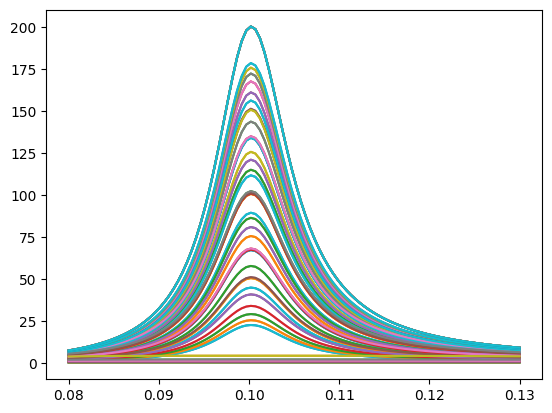

In [26]:
w = np.linspace(0.08, 0.13, 100)

def qedNRG(w_i, ti, tf):
    mu_i = np.cos(ti)
    mu_f = np.cos(tf)
    dMu = mu_f - mu_i
    w_f = (1.0 + w_i*(1.0 - mu_i*mu_f) - np.sqrt(1.0 + 2.0*w_i*mu_f*dMu + w_i*w_i*dMu*dMu)) / (1.0 - mu_f*mu_f)
    
    if (np.abs(mu_f) == 1.0):
        w_f = 0.5 * ((w_i*w_i * (1.0 - mu_i*mu_i) + 2.0*w_i) / (1.0 + w_i*(1.0 - mu_i)))

    return w_f

# plt.plot(w, nonCenteredNrgVoigt(w, 0.0001, 0.0001, 0.1))
for ti in np.acos(np.linspace(-1, 1, 10)):
    for tf in np.acos(np.linspace(-1, 1, 10)):
        plt.plot(w, qedNRG(SigBG(w, 0.1, 0.01, 1), ti, tf))

plt.show()

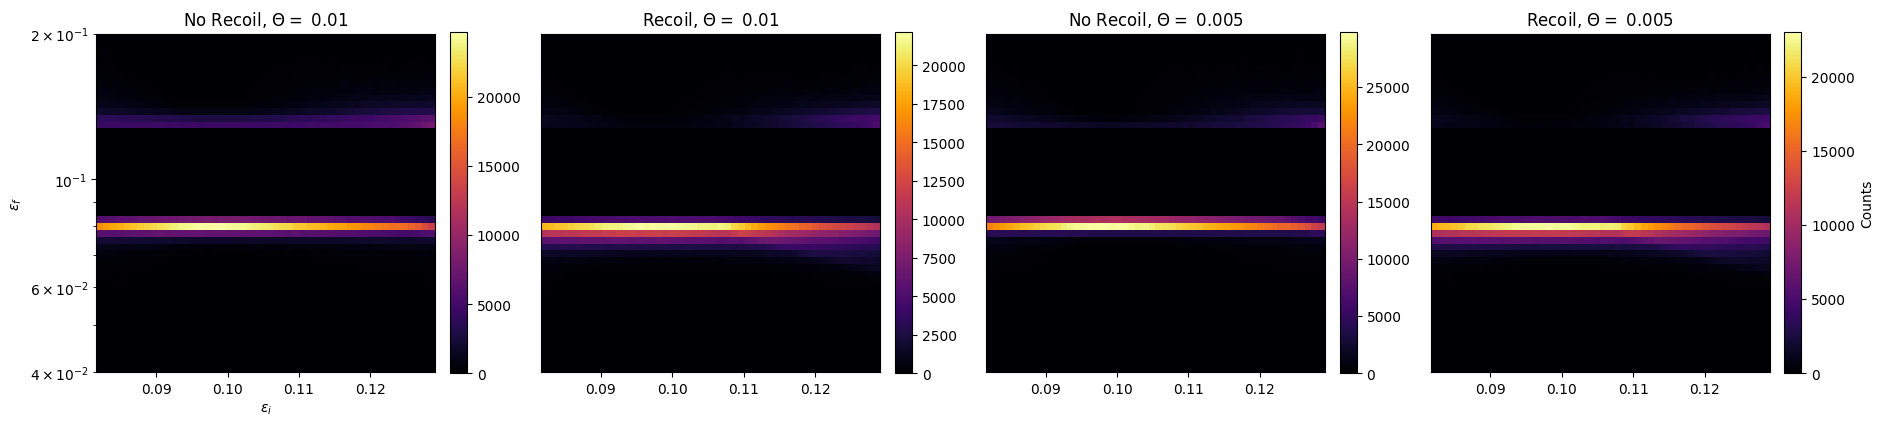

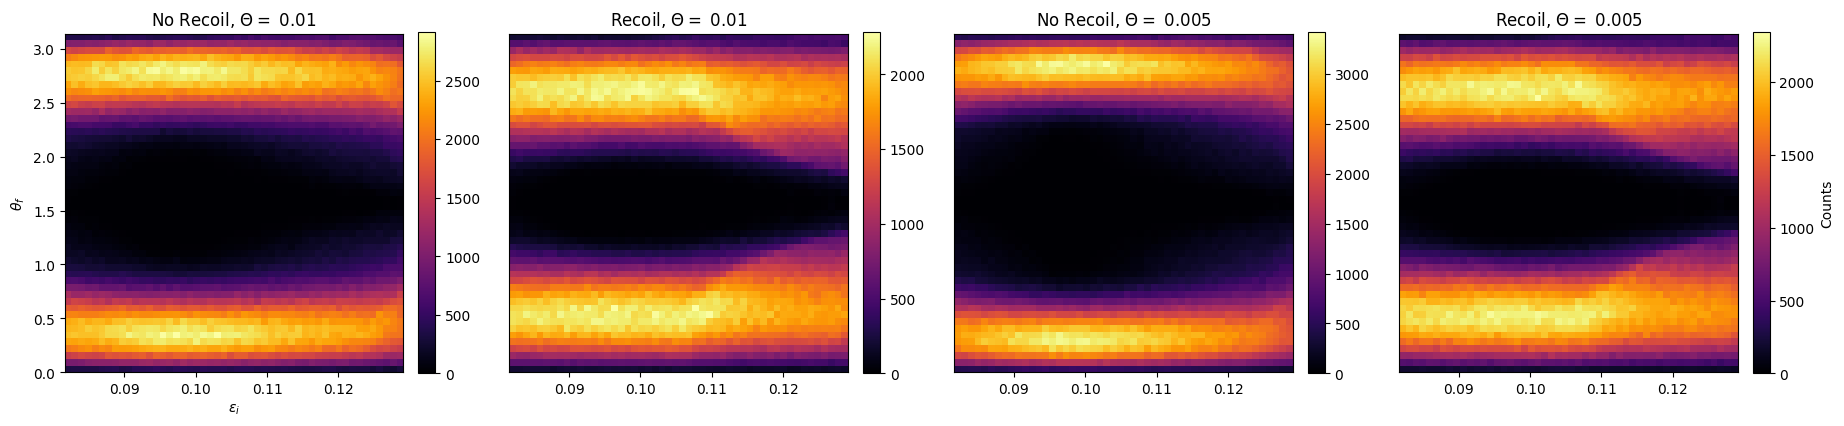

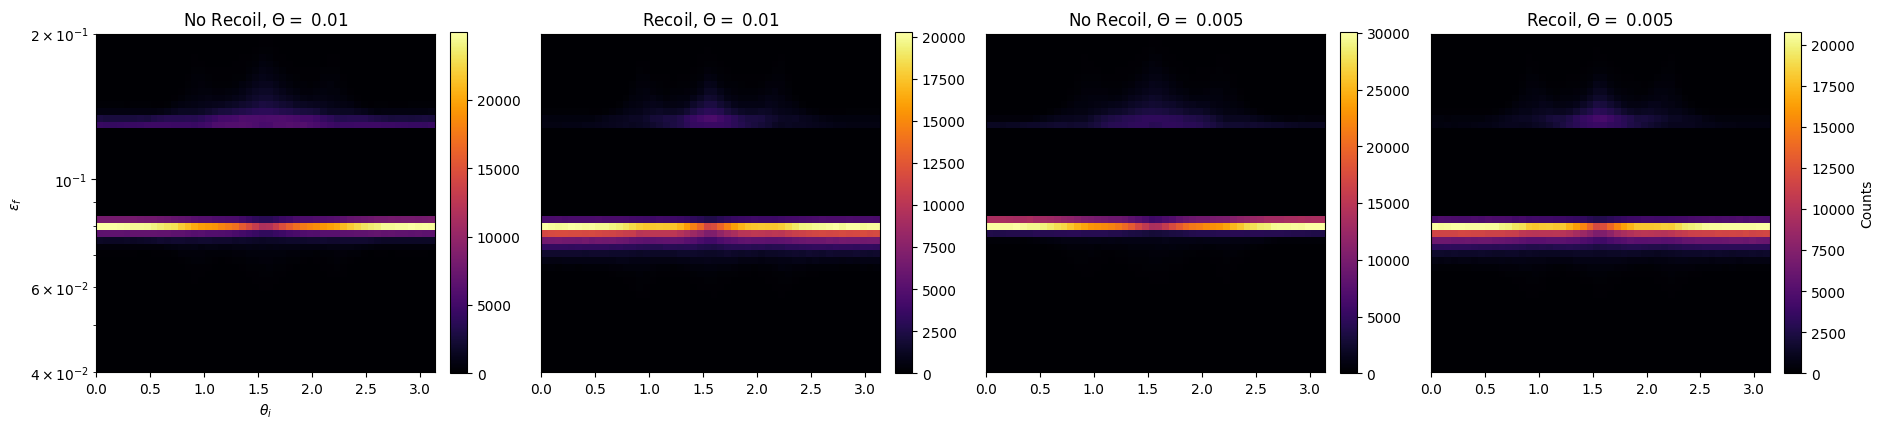

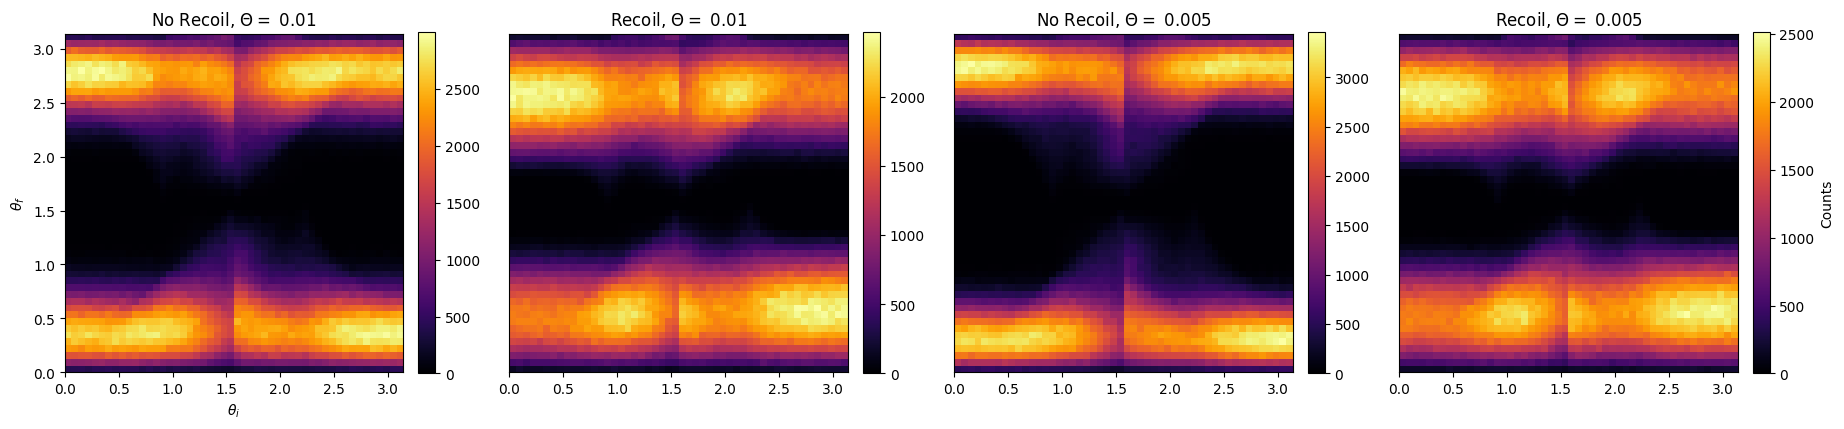

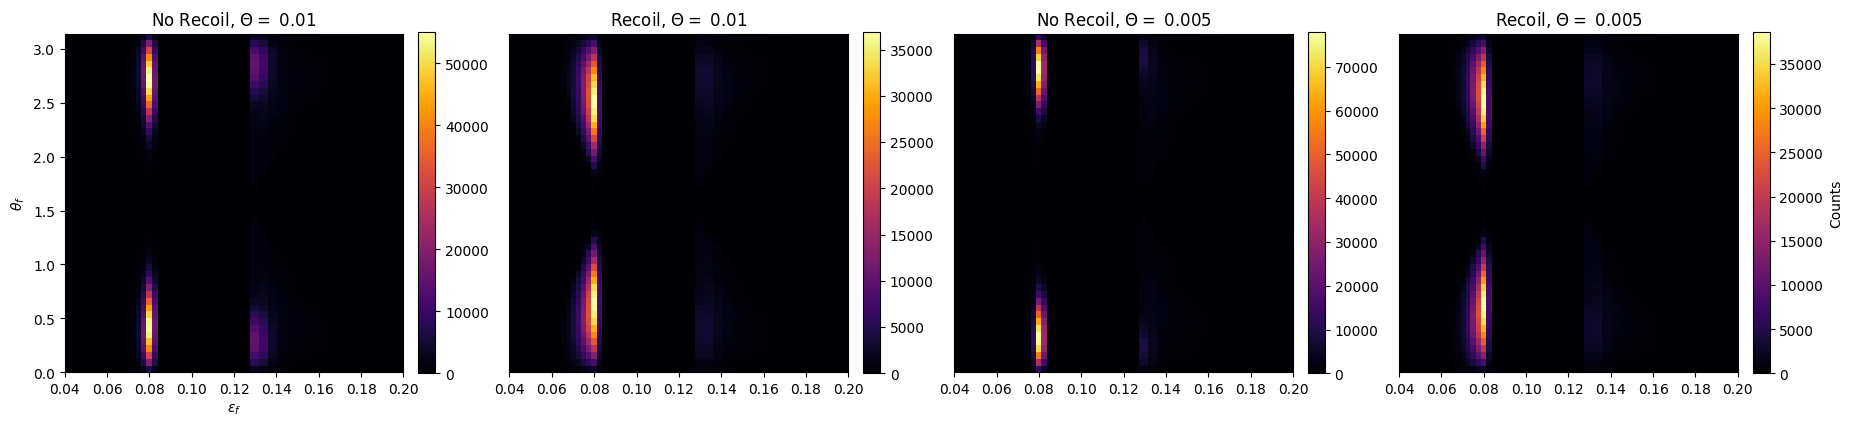

In [33]:
def getAxesFromKey(key):
    if key[0:3] == "nrg":
        xlabel = fr"$\varepsilon_i$"
    else:
        xlabel = fr"$\theta_i$"
        
    if (key[-3:] == "nrg"):
        ylabel = fr"$\varepsilon_f$"
    else:
        ylabel = fr"$\theta_f$"

    if (key == "finalVals"):
        xlabel = fr"$\varepsilon_f$"
        ylabel = fr"$\theta_f$"

    return (xlabel, ylabel)

def plot2DHists(key, i, ax):
    # Get relevant 2D hist
    thisHist2D = hists2D[i][key]

    xWalls = thisHist2D["xWalls"]
    yWalls = thisHist2D["yWalls"]

    image = ax.pcolormesh(xWalls, yWalls, thisHist2D["totalCounts"], cmap=myMap)

    xlabel, ylabel = getAxesFromKey(key)

    if (i == 0):
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
    else:
        ax.get_yaxis().set_visible(False)
    
    if (ylabel==fr"$\varepsilon_f$"):
        ax.set_yscale('log')

    cbar = plt.colorbar(image, ax=ax, fraction=0.046, pad=0.04)

    if (i == 3):
        cbar.set_label("Counts")

    ax.set_box_aspect(1)

    # figure out the title
    ax.set_title(titleFromFolder(folderNames[i]))

plotAllKeys(["nrgXnrg", "nrgXtheta", "thetaXnrg", "thetaXtheta", "finalVals"], plot2DHists)

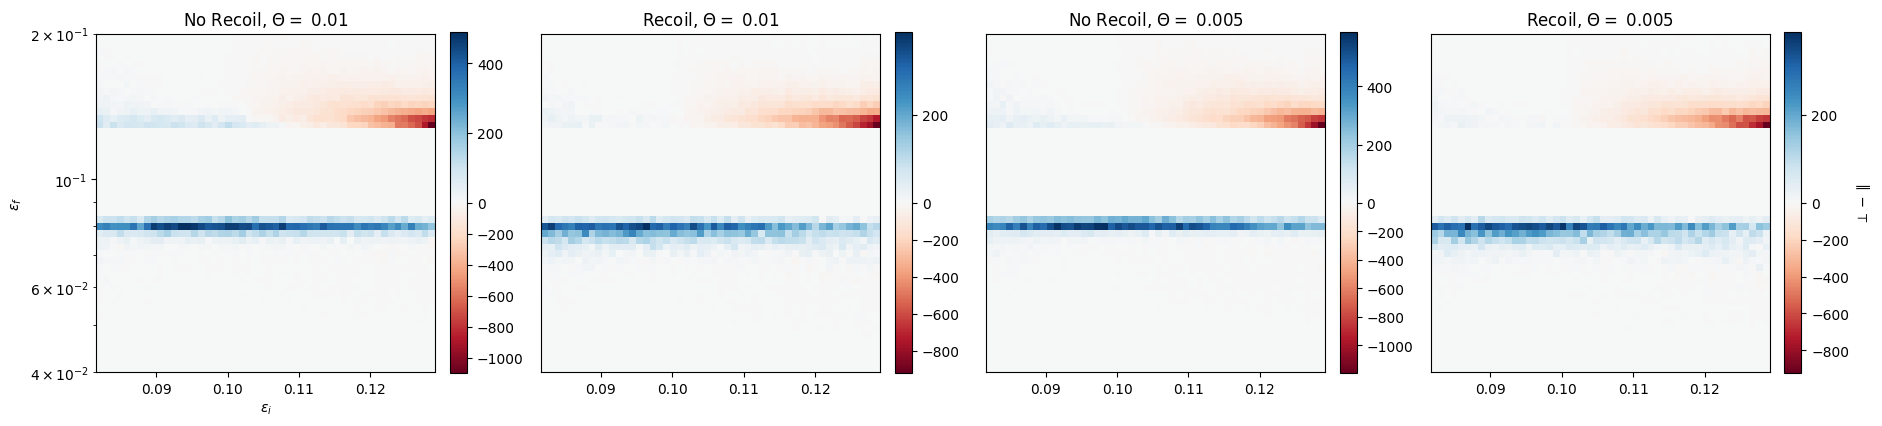

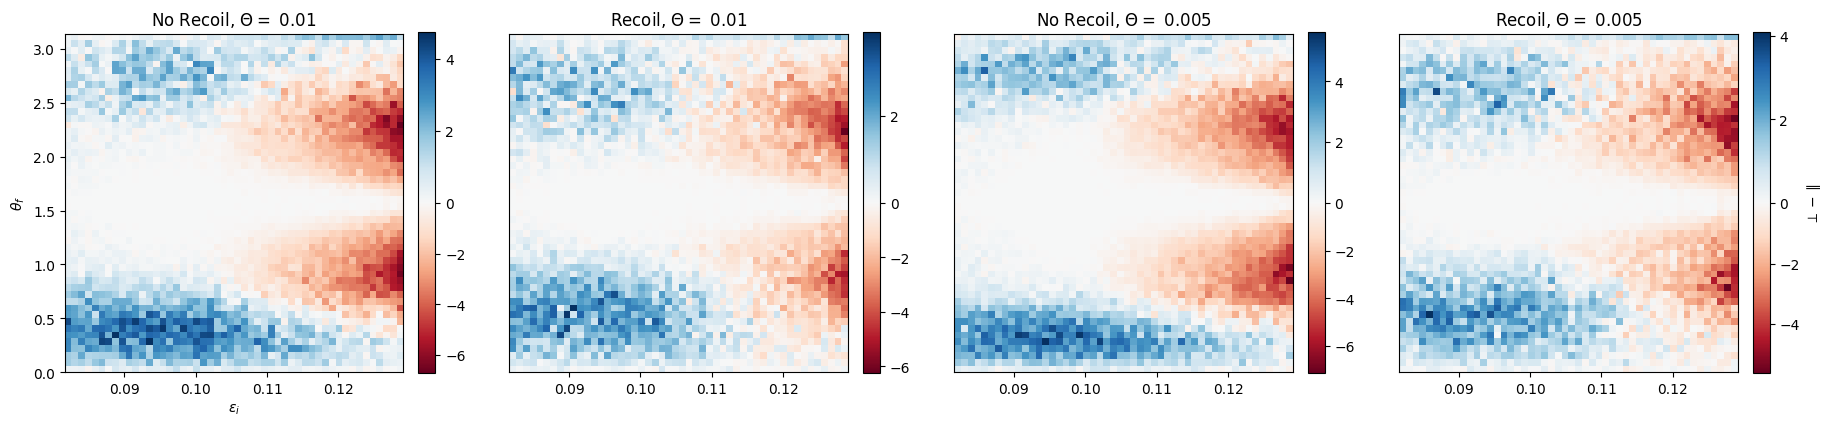

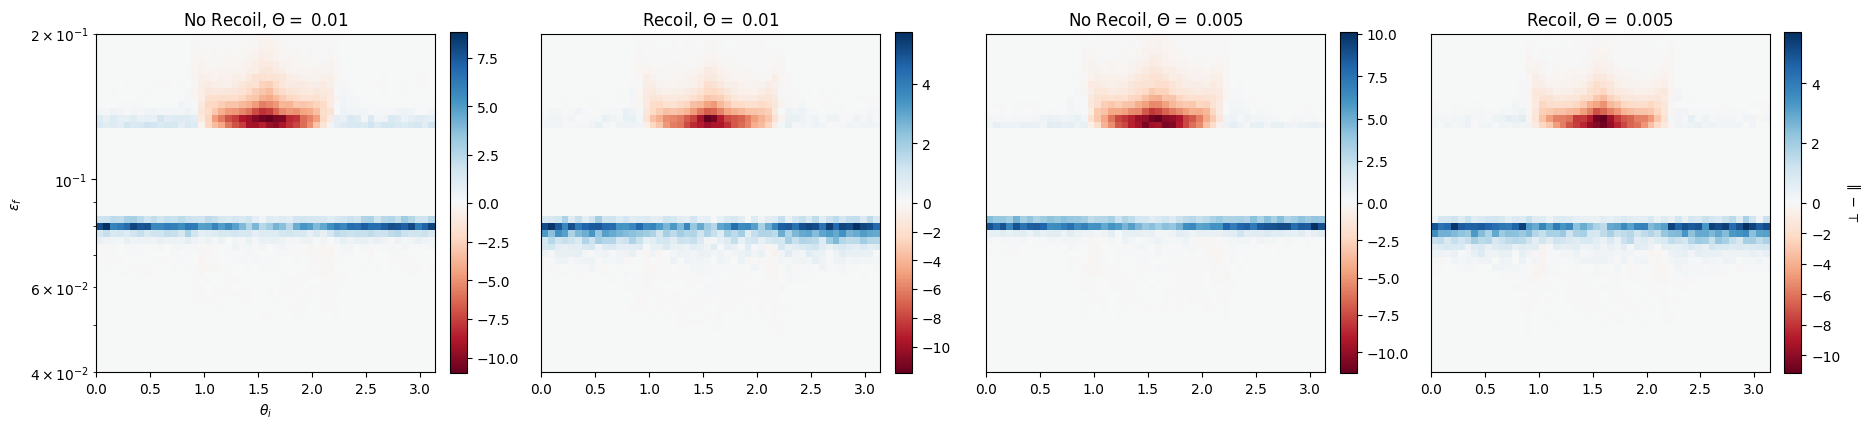

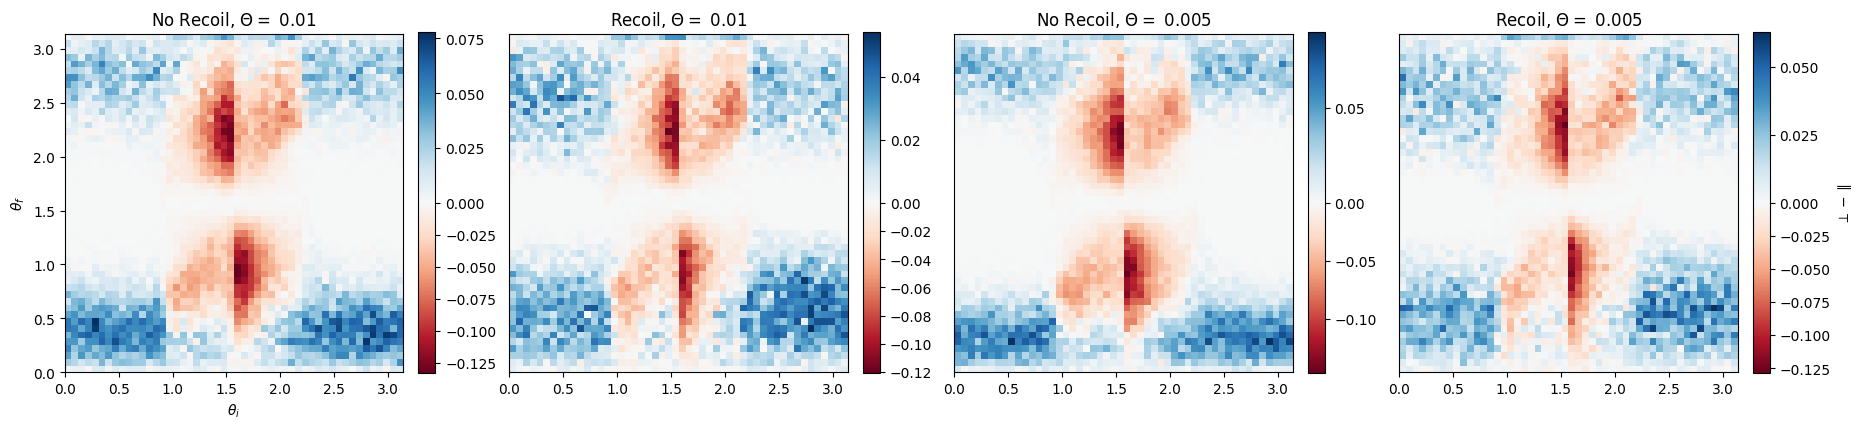

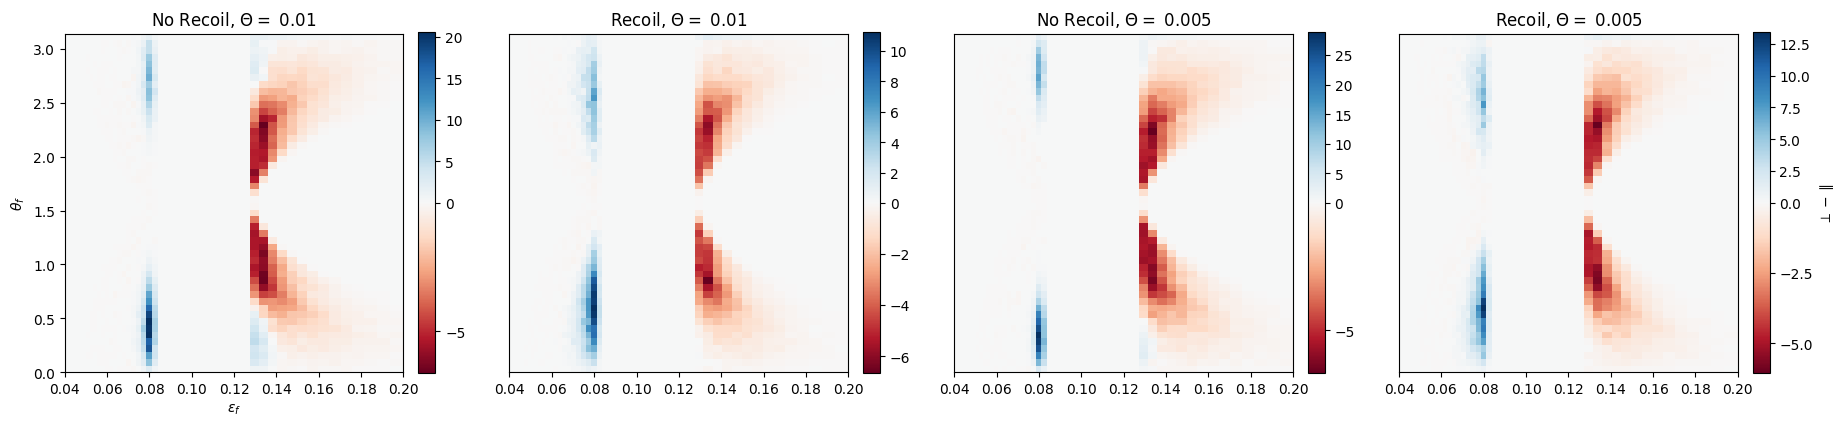

In [34]:
def plot2DHistDiffs(key, i, ax):
    # Get relevant 2D hist
    thisHist2D = hists2D[i][key]

    xWalls = thisHist2D["xWalls"]
    xVals = np.linspace(xWalls[0], xWalls[-1], xWalls.size-1) 
    yWalls = thisHist2D["yWalls"]
    yVals = np.linspace(yWalls[0], yWalls[-1], yWalls.size-1)

    normArrays = []
    for count in ("totalCounts", "perpCounts", "parCounts"):
        intVal = np.trapezoid(np.trapezoid(thisHist2D[count], yVals, axis=0), xVals, axis=0)
        normArrays.append(thisHist2D[count]/intVal)

    plotVals = normArrays[1] - normArrays[2]
    # plotVals = normArrays[0]

    divnorm=colors.TwoSlopeNorm(vcenter=0.)
    image = ax.pcolormesh(xWalls, yWalls, plotVals, cmap='RdBu', norm=divnorm)

    xlabel, ylabel = getAxesFromKey(key)

    if (i == 0):
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
    else:
        ax.get_yaxis().set_visible(False)

    if (ylabel==fr"$\varepsilon_f$"):
        ax.set_yscale('log')

    cbar = plt.colorbar(image, ax=ax, fraction=0.046, pad=0.04)

    if (i == 3):
        cbar.set_label(r"$\perp - \parallel$")

    ax.set_box_aspect(1)

    # figure out the title
    ax.set_title(titleFromFolder(folderNames[i]))

# BLUE: PERP, RED: PAR
plotAllKeys(["nrgXnrg", "nrgXtheta", "thetaXnrg", "thetaXtheta", "finalVals"], plot2DHistDiffs)